<center><br><font size=10> Final Project - Group 6</font><br>
<br><br>
<b>Introduction to Machine Learning – Digital Sciences for High-Tech</b>
<br><br>
<b>Author</b>: Shani Hazan (shanihazan1@mail.tau.ac.il) and Sheli Feigin (shelifeigin@mail.tau.ac.il)
<br><i>Spring 2023</i></center>

#### <font color=white>Import libraries</font>



In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import (
    auc,
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix,
    mean_squared_error,
    RocCurveDisplay,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from PIL import Image
import requests
from io import BytesIO
import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.precision", 2)

#### <font color=white>Loading the data</font>

First of all we will load both the 'train' data and the 'test' data :

In [6]:
files = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## <font color=white>Part 1 - Exploration of the data</font>
Let's get to know our data set by looking at it briefly.

In [7]:
files.head()

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6.80e+06,524.0,3.0,0.0,1.0,1.0,0.0,1.0,...,0.0,28.0,899075.0,13.86,Win32 EXE PECompact compressed (generic),64.2,-3.98,5.73,er,1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,4.51e+04,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,856.0,9.62,Win32 Dynamic Link Library (generic),38.4,7.06,5.74,er,0
2,b0b126adc73b980a114e38027b082d149fcf491547452f...,686136,7.05e+05,133.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,2.0,32767.0,12.14,Win64 Executable (generic),82.0,1.05,5.72,gow,0
3,ff6176c53ca9b58040c93870c264843b93b5e290c28e57...,8192,3.69e+04,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,678.0,9.55,Win64 Executable (generic),28.0,2.22,5.90,vh,1
4,59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...,396288,4.22e+05,133.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,5.0,35881.0,7.59,Win64 Executable (generic),32.2,9.40,NaN,vh,1


We can notice that each file has **24 features**, one of the features is called **'label'** and its meaning is whether the file is malicious (1) or benign (0) .

From a first glance, it seems that the **'Sha256'** feature, which means a unique identifier for the file, does not contribute to whether the file is malicious, so we will **remove it** during the pre-processing stage.

In [8]:
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               60000 non-null  object 
 1   size                 60000 non-null  int64  
 2   vsize                58065 non-null  float64
 3   imports              58261 non-null  float64
 4   exports              57907 non-null  float64
 5   has_debug            57073 non-null  float64
 6   has_relocations      56676 non-null  float64
 7   has_resources        58039 non-null  float64
 8   has_signature        58063 non-null  float64
 9   has_tls              57102 non-null  float64
 10  symbols              57344 non-null  float64
 11  numstrings           57282 non-null  float64
 12  paths                56340 non-null  float64
 13  urls                 57651 non-null  float64
 14  registry             57475 non-null  float64
 15  MZ                   56911 non-null 

The features are divided into 2 types: numeric values (int and float) and string (object).

The format of **'file_type_trid'** and **'C'** is object so we will convert both to numerical values ​​because some of the models we will use will only require numerical values ​​to operate.

In addition, we notice that there are features that are missing values, we will check this matter during this stage.

It is also worth mentioning that there are 3 anonymous characteristics: **'A', 'B', 'C'** whose We will try to find out how they contribute to our model.

In [9]:
files.describe(include="all")

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
count,60000,6.00e+04,5.81e+04,58261.00,57907.00,57073.00,56676.00,58039.00,58063.00,57102.00,...,57475.00,56911.00,5.73e+04,57243.00,60000,60000.00,56296.00,5.62e+04,57949,60000.0
unique,60000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,89,NaN,NaN,NaN,7,NaN
top,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Win64 Executable (generic),NaN,NaN,NaN,vh,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10085,NaN,NaN,NaN,23226,NaN
mean,NaN,1.50e+06,1.97e+06,106.20,30.80,0.40,0.54,0.86,0.25,0.23,...,0.43,16.26,1.21e+05,32.66,NaN,53.68,4.02,5.81e+00,NaN,0.5
std,NaN,4.73e+06,2.02e+07,213.45,508.08,0.49,0.50,0.35,0.44,0.42,...,11.50,82.19,6.05e+05,1094.71,NaN,20.63,6.37,6.41e-01,NaN,0.5
min,NaN,2.98e+02,5.44e+02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,5.00e+00,5.00,NaN,17.50,-17.78,4.93e-03,NaN,0.0
25%,NaN,1.07e+05,1.23e+05,1.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,1.00,6.01e+03,7.45,NaN,38.40,-0.29,5.47e+00,NaN,0.0
50%,NaN,4.83e+05,4.22e+05,28.00,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,4.00,2.28e+04,12.01,NaN,43.30,3.66,5.86e+00,NaN,0.5
75%,NaN,1.24e+06,1.60e+06,152.00,0.00,1.00,1.00,1.00,1.00,0.00,...,0.00,11.00,7.62e+04,17.31,NaN,69.10,7.86,6.34e+00,NaN,1.0


We can see that there are 7 unique values of the categorial feature **'C'** and 89 of **'file_type_trid'** so we will take this into account when we want to convert them to numeric.

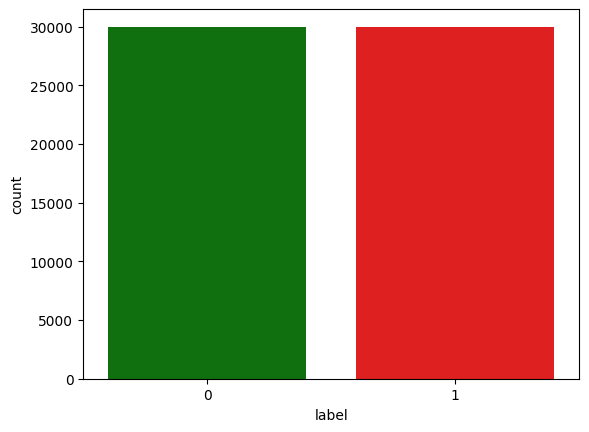

In [10]:
sns.countplot(data=files, x="label", palette=["green", "red"])
plt.show()

This plot indicates that **the data is balanced**, half of the files are malicious and the other half are benign. This helps divide the whole data to train and validation in a balanced way.

#### <font color=white>Looking for features with abnormal amount of missing values</font>
In order to see if there are columns with unusually high percentages of missing values, we will look at a chart indicating the percentage of null values for each feature.

In [11]:
null_percentages = ((files.isnull().sum() / len(files)) * 100).sort_values(
    ascending=False
)
null_table = pd.DataFrame(
    {"Feature": null_percentages.index, "% Null values": null_percentages.values}
)
null_table

,Feature,% Null values
0,B,6.25
1,A,6.17
2,paths,6.10
3,has_relocations,5.54
4,MZ,5.15
5,has_debug,4.88
6,has_tls,4.83
7,avlength,4.59
8,printables,4.57
9,numstrings,4.53


As we can see, there are 5 features that have no missing values and the other features have a **relatively low percentage of missing values**, so we will fill them in the pre-processing stage.

 ####  <font color=white>The feature distributions</font> 

We will present the distributions of all the features except: <br>
**'label'**- which is the prediction <br>
**'sha256'**- which we found to be correct to remove in the pre-processing stage <br>
 **'C'** and **'file_type_trid'** categorical features

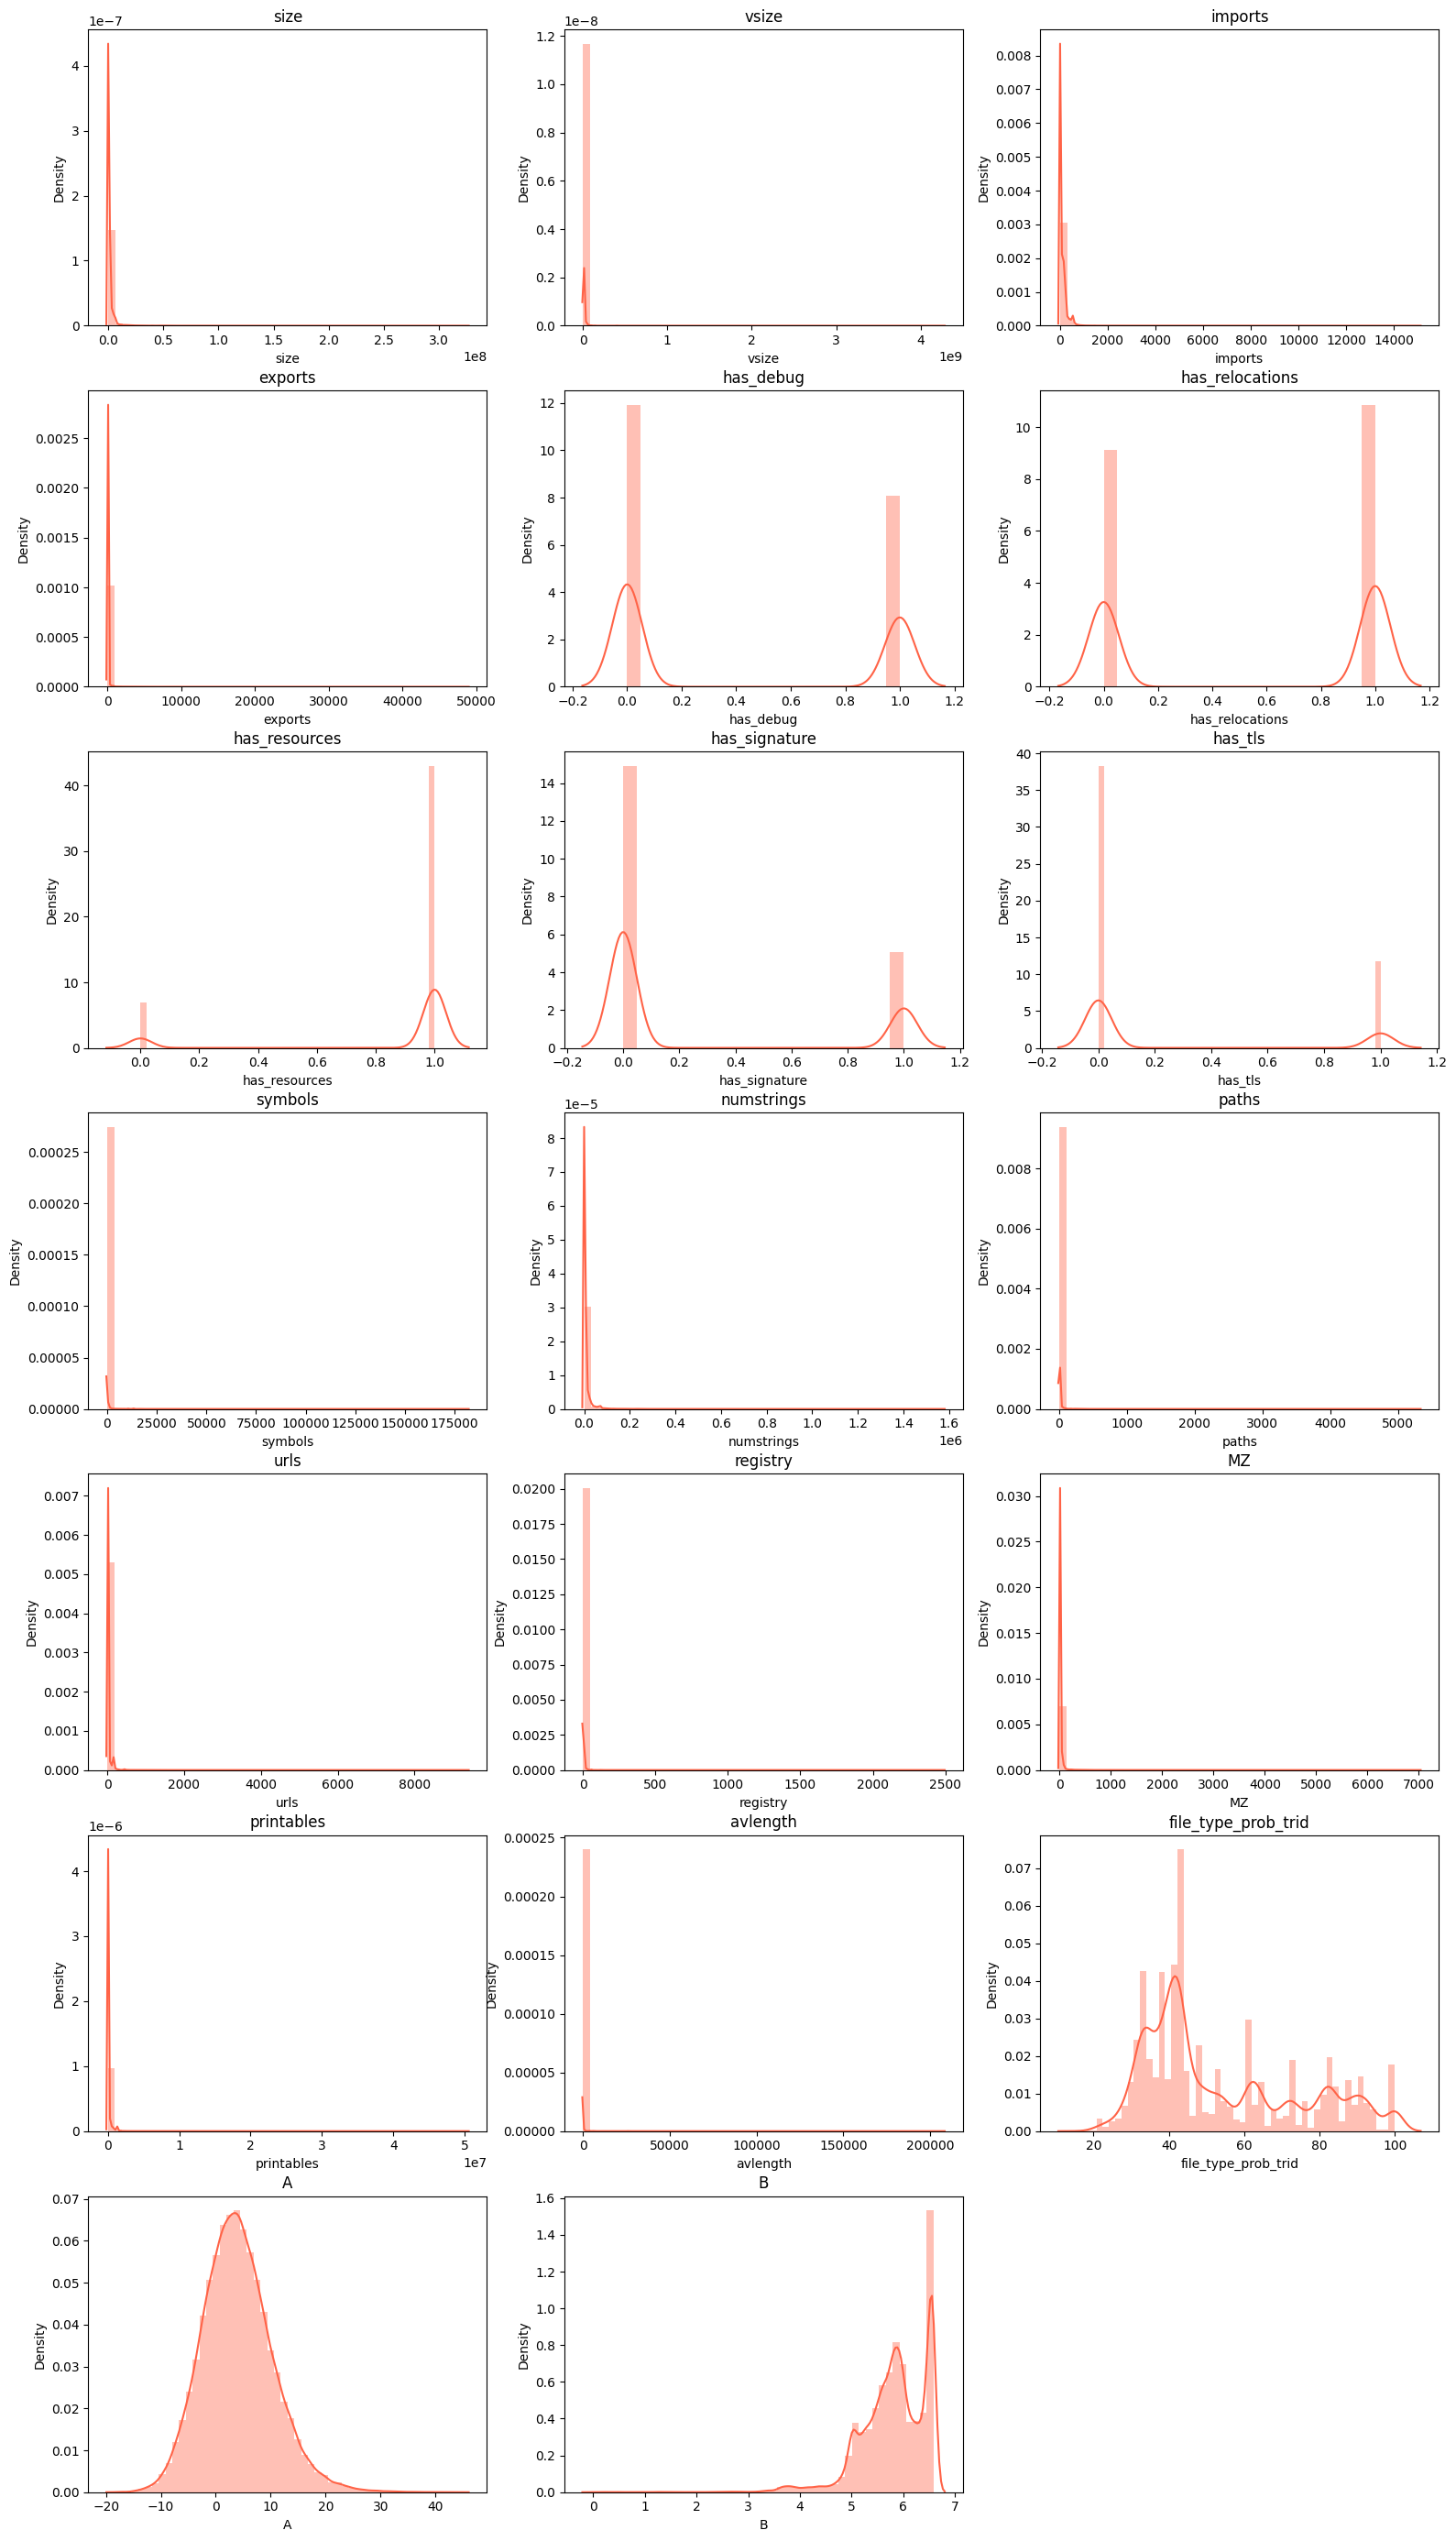

In [12]:
def plot_distribution_withoutlog(df):
    columns = [
        "size",
        "vsize",
        "imports",
        "exports",
        "has_debug",
        "has_relocations",
        "has_resources",
        "has_signature",
        "has_tls",
        "symbols",
        "numstrings",
        "paths",
        "urls",
        "registry",
        "MZ",
        "printables",
        "avlength",
        "file_type_prob_trid",
        "A",
        "B",
    ]
    num_columns = len(columns)
    rows = (num_columns - 1) // 3 + 1

    fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows))
    plt.tight_layout(pad=3)

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.distplot(df[column], color="tomato", ax=ax).set_title(column)

    # Remove the empty subplot
    fig.delaxes(axes[6, 2])

    plt.show()


plot_distribution_withoutlog(files)

It can be seen from the graphs that there are **5 binary features ('0' \\ '1')**, which we will consider below.

Now, we will **add 'log'** to the distribution and check if we got a cleaner distribution : <br> (The distributions of binary features have no meaning, so we will not include them in the distributions below).

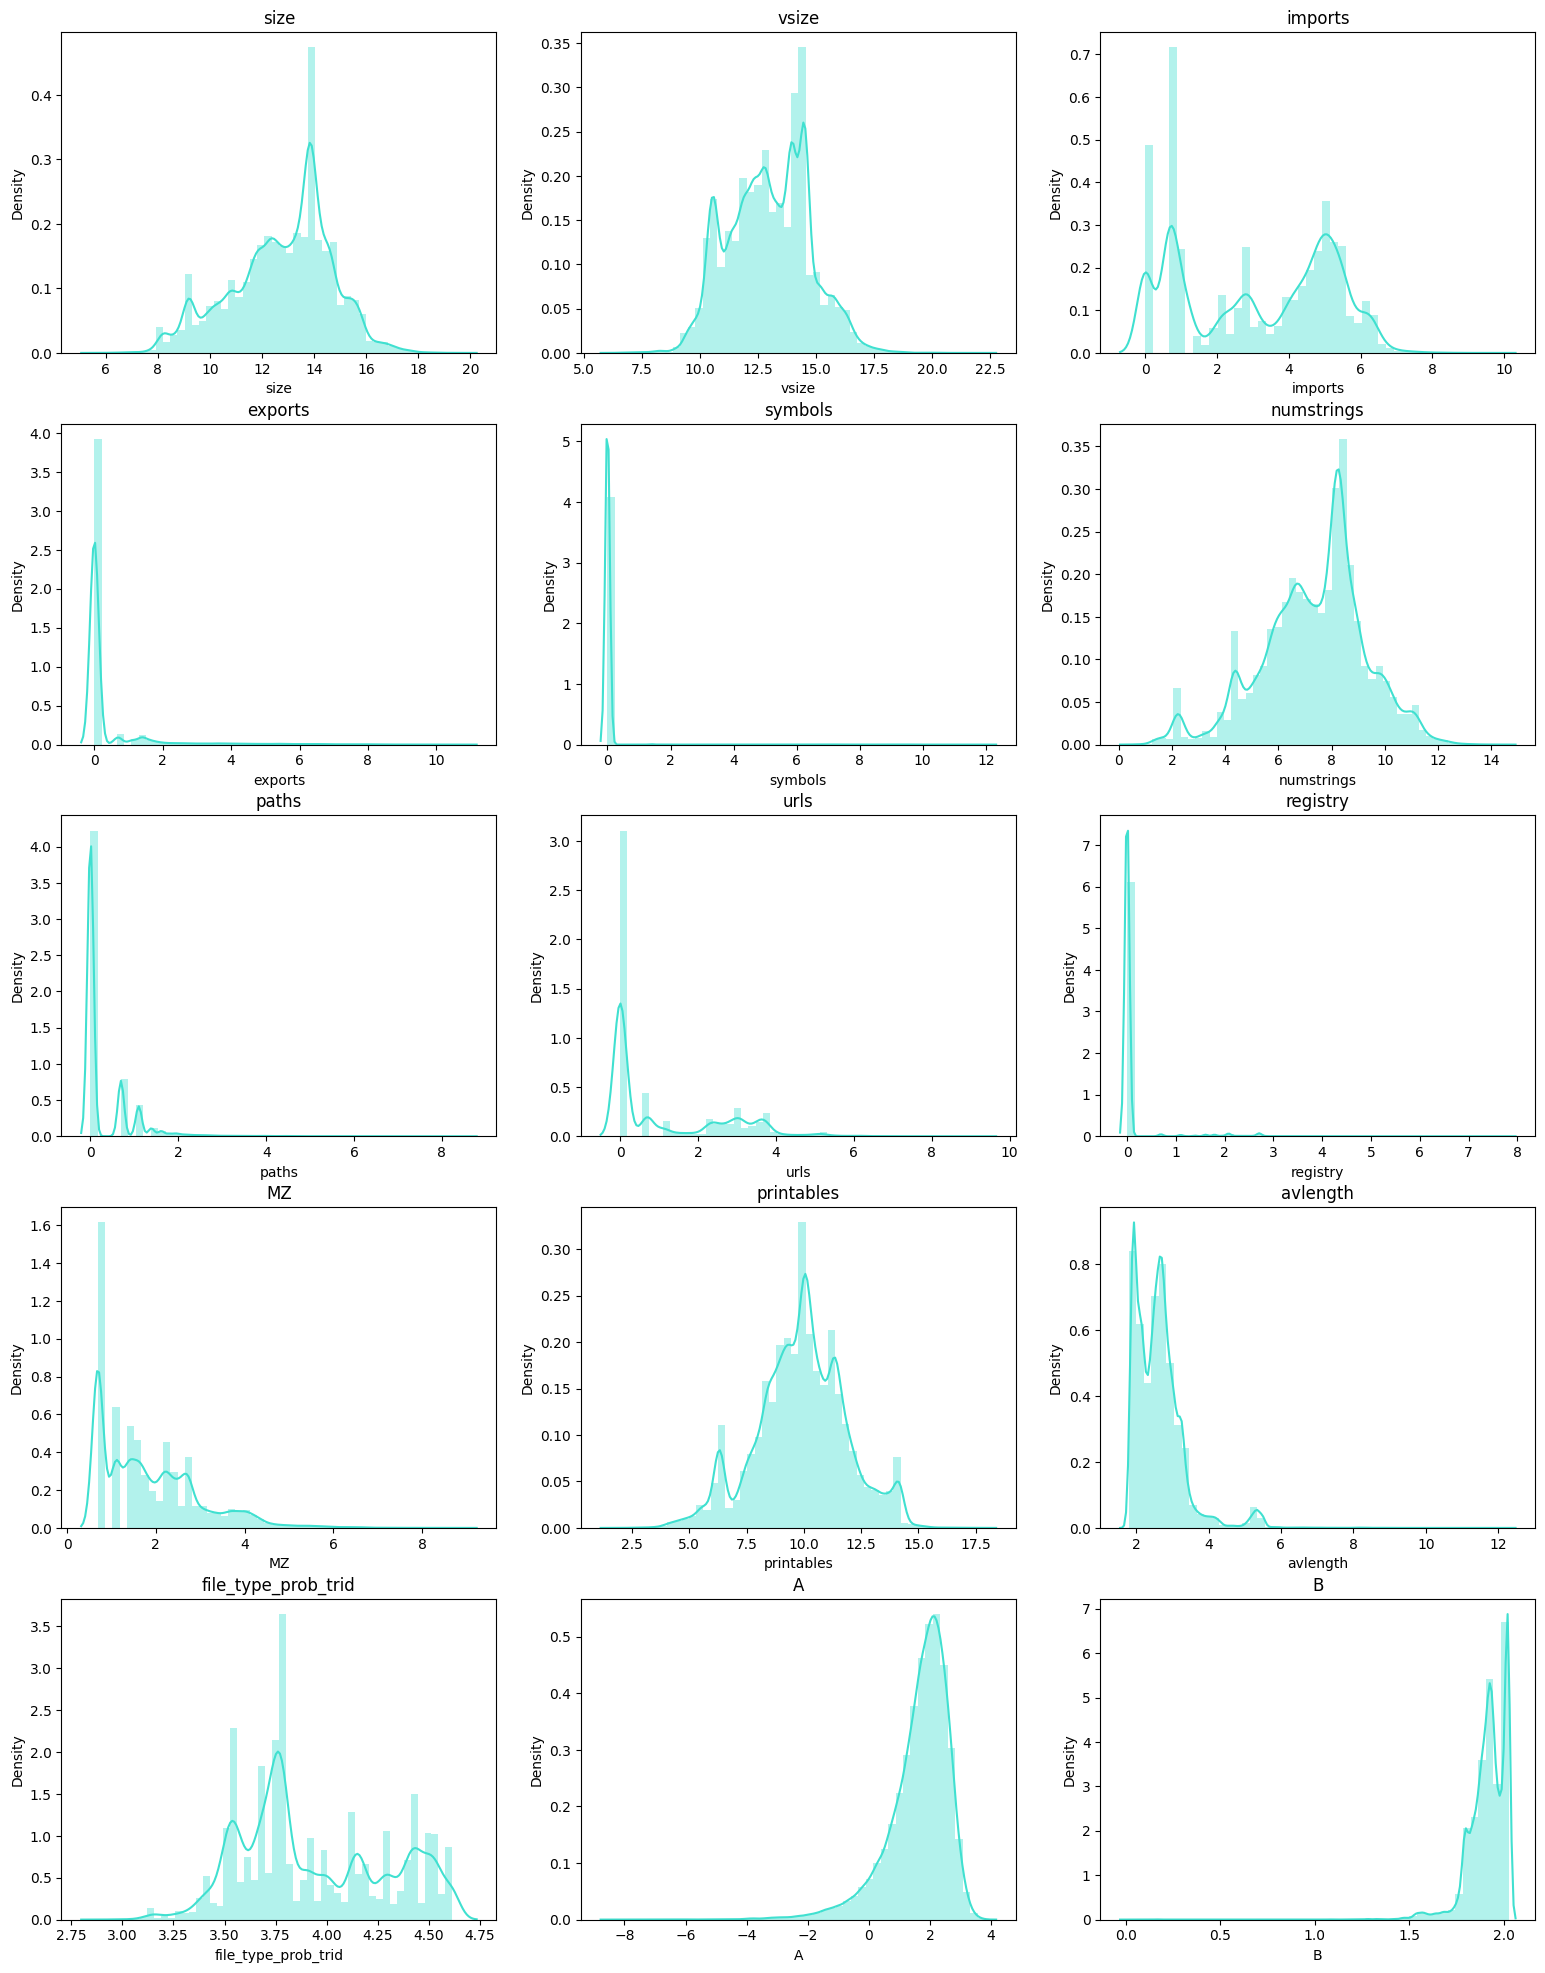

In [13]:
# Add 'Log' to the distributions


def plot_distribution(df):
    columns = [
        "size",
        "vsize",
        "imports",
        "exports",
        "symbols",
        "numstrings",
        "paths",
        "urls",
        "registry",
        "MZ",
        "printables",
        "avlength",
        "file_type_prob_trid",
        "A",
        "B",
    ]
    num_columns = len(columns)
    rows = (num_columns - 1) // 3 + 1

    fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows))
    plt.tight_layout(pad=3)

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.distplot(np.log1p(df[column]), color="turquoise", ax=ax).set_title(column)

    plt.show()


plot_distribution(files)

The conclusion is that **'Log'** gives better visualization so the graphs look clearer. We'll remeber this in the preprocessing stage, **there we will perform log manipulation on existing features.**


There are several things that can be deduced from looking at the distributions:

First of all, as we have already concluded, there are 5 binary features ('0' \\ '1'): **has_debug**, **has_relocations**, **has_tls**, **has_signature**, **has_resources**.

The second thing is that there are several common distributions among the features:
1. **size**, **vsize**, **numstrings**, **printabels**, **A** - similar to gaussian distribution.
3. **imports**, **file_type_prob_trid** - doesn't look like a familiar distribution.
4. **exports**, **symbols**, **paths**, **urls**, **registry**, **MZ**, **avlength** - skewed to the right.
5. **B** - skewed to the left.

At the step of filling in the missing values, we will take into account the distributions we found.

####  <font color=white>Correlation matrix</font>

Now, we will examine which features are correlated with each other and what is the strength of the relationship between them:

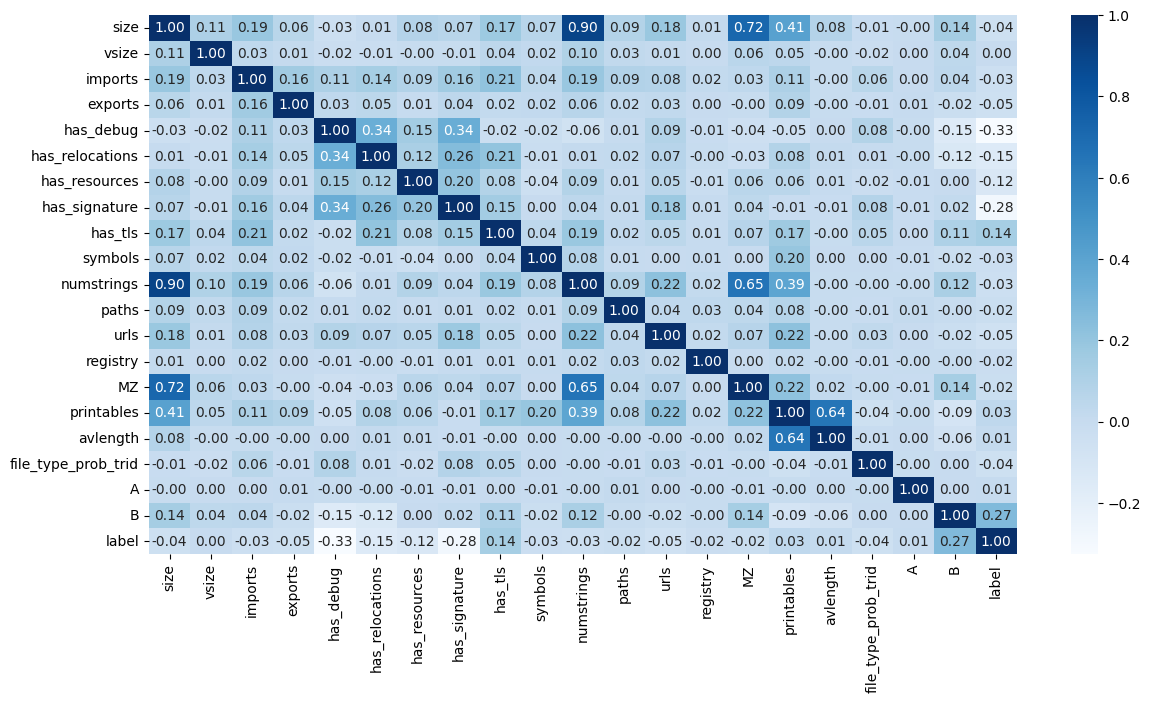

In [14]:
plt.figure(figsize=(14, 7))
sns.heatmap(files.corr(numeric_only=True), annot=True, cmap="Blues", fmt=".2f")
plt.show()

When looking at the correlation matrix, the thing that we need to take into consideration is the correlation between the features.

<u>The main things that we see are:</u>

1.  A high correlation between **'size'** and **'num_strings'** (0.91) - This correlation make sense because the more strings there are, the larger the file is, we note that it is not correct to say the opposite - that the larger the file, the more strings it contains

2. A high correlation between **'size'** and **'MZ'** (0.72) - This correlation is very high and made us wonder about the data, most files start with the MZ string, the more MZ instances there are in the file, the more files it will contain, so it will be a very large file. In addition, we can assume that if this is the case, the file is probably a virus that contains many executable files in it.

We can see that the feature **'size'**  has a high correlation with many features in additon to the features: **'num_strings'** and **'MZ'**, so we will take this into account later - we will **remove the 'size' feature or perform a linear combination of it with the features with which it has a high correlation.**

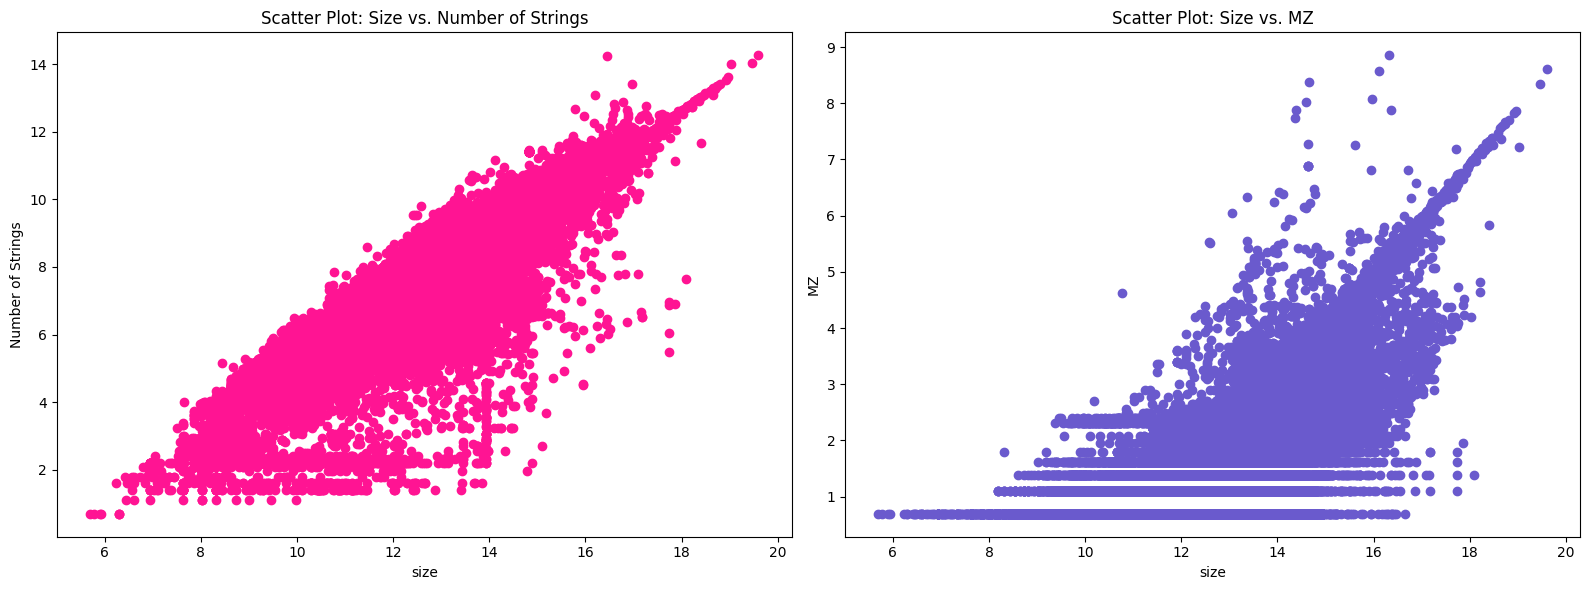

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot 1: Size vs. Number of Strings
axes[0].scatter(
    np.log1p(files["size"]), np.log1p(files["numstrings"]), color="deeppink"
)
axes[0].set_xlabel("size")
axes[0].set_ylabel("Number of Strings")
axes[0].set_title("Scatter Plot: Size vs. Number of Strings")

# Scatter plot 2: Size vs. MZ
axes[1].scatter(np.log1p(files["size"]), np.log1p(files["MZ"]), color="slateblue")
axes[1].set_xlabel("size")
axes[1].set_ylabel("MZ")
axes[1].set_title("Scatter Plot: Size vs. MZ")

plt.tight_layout()
plt.show()

<u>Explanation of the visualizations:</u> <br>

Following the correlations we found, we assumed that there would be a linear relationship between the features mentioned above and we wanted to see this visually through a plot. <br>
Indeed, it seems that **the relationship is mainly linear.** <br>
Furthermore, we emphasize that it is logical and expected that the relationship between 'size' and 'numstrings' (0.91) will be more linear than the relationship between 'size' and 'MZ' (0.72).

#### <font color=white>Identify the feature values ​​for which a file is likely to be classified as malicious</font>

Now, we'd like to test what kind of connection the file's maliciousness has with each of the 5 **binary features**:

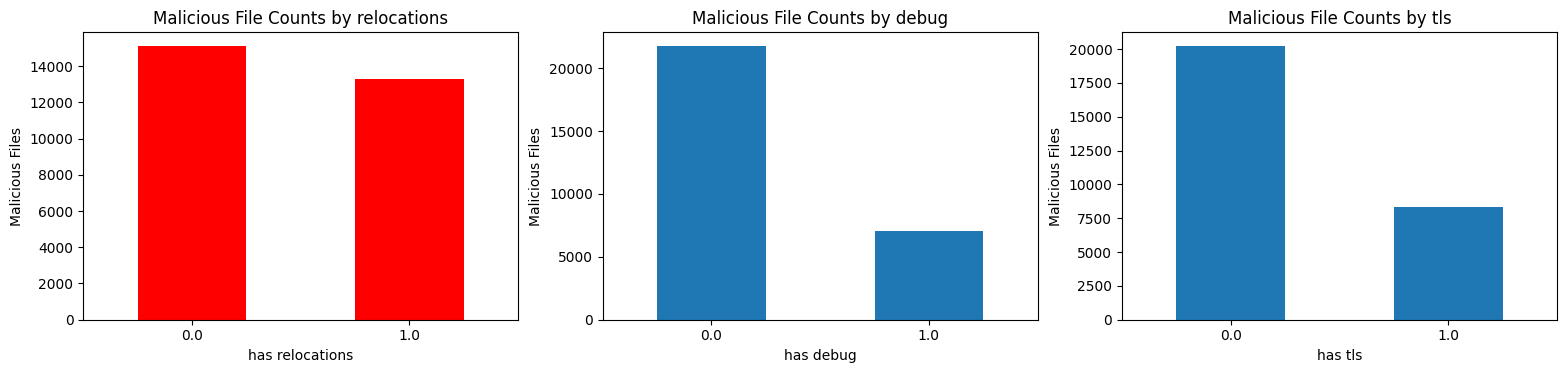

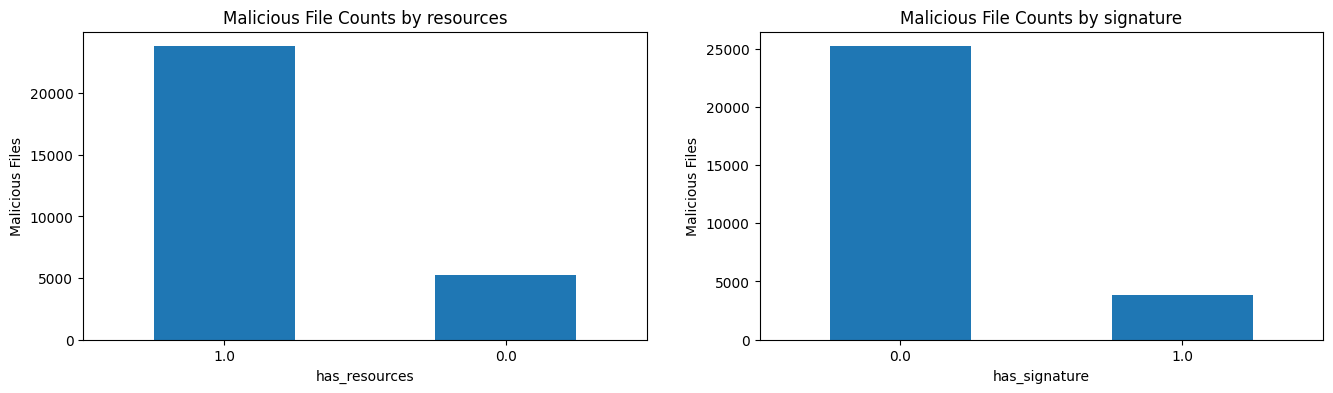

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plt.tight_layout(pad=3)

# Plot 1: has relocations
malicious_counts_by_Relocations = (
    files[["has_relocations", "label"]]
    .groupby("has_relocations")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)
malicious_counts_by_Relocations.plot(kind="bar", legend=False, ax=axes[0], color="red")
axes[0].set_xlabel("has relocations")
axes[0].set_ylabel("Malicious Files")
axes[0].set_title("Malicious File Counts by relocations")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot 2: has debug
malicious_counts_by_Debug = (
    files[["has_debug", "label"]]
    .groupby("has_debug")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)
malicious_counts_by_Debug.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_xlabel("has debug")
axes[1].set_ylabel("Malicious Files")
axes[1].set_title("Malicious File Counts by debug")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Plot 3: has tls
malicious_counts_by_TLS = (
    files[["has_tls", "label"]]
    .groupby("has_tls")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)
malicious_counts_by_TLS.plot(kind="bar", legend=False, ax=axes[2])
axes[2].set_xlabel("has tls")
axes[2].set_ylabel("Malicious Files")
axes[2].set_title("Malicious File Counts by tls")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)


fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plt.subplots_adjust(wspace=0.2)
# Plot 1: has resources
malicious_counts_by_Relocations = (
    files[["has_resources", "label"]]
    .groupby("has_resources")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)
malicious_counts_by_Relocations.plot(kind="bar", legend=False, ax=axes[0])
axes[0].set_xlabel("has_resources")
axes[0].set_ylabel("Malicious Files")
axes[0].set_title("Malicious File Counts by resources")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plot 2: has signature
malicious_counts_by_Debug = (
    files[["has_signature", "label"]]
    .groupby("has_signature")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)
malicious_counts_by_Debug.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_xlabel("has_signature")
axes[1].set_ylabel("Malicious Files")
axes[1].set_title("Malicious File Counts by signature")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.show()

As you can see, the feature **'has_relocations' do not help identify whether the file is malicious** - there is a fairly equal number of malicious files that are classified as 1 and 0 so we will **remove this feature later.** <br> 
On the other hand, in the graphs of the other features it can be seen absolutely that most of the malicious files mainly receive a specific value (0\1) and therefore contribute to our model.

<u>Now we will examine what happens with our 2 **categorical features**:</u>

In [17]:
malicious_counts_by_file_type = (
    files[["file_type_trid", "label"]]
    .groupby(
        "file_type_trid",
    )
    .sum()
    .rename(columns={"label": "malicious files"})
)

total_files_by_file_type = files["file_type_trid"].value_counts()
malicious_counts_by_file_type["% malicious files"] = (
    malicious_counts_by_file_type["malicious files"] / total_files_by_file_type * 100
)

malicious_counts_by_file_type.sort_values(
    by="% malicious files", ascending=False, inplace=True
)
malicious_counts_by_file_type.drop("malicious files", axis=1, inplace=True)
malicious_counts_by_file_type = malicious_counts_by_file_type.head(20)
print(malicious_counts_by_file_type)

                                           % malicious files
file_type_trid                                              
Microsoft Input Method Editor                         100.00
Win32 Executable kkrunchy compressed                  100.00
foobar 2000 generic component                         100.00
Mew compressed Win32 Executable                       100.00
DOS Executable Generic                                 99.30
Win32 Executable PureBasic (generic)                   97.01
Win16 NE executable (generic)                          89.15
MinGW32 C/C++ Executable                               80.77
Petite compressed Win32 executable                     78.95
UPX compressed Win32 Executable                        78.17
Win32 Executable MS Visual C++ 5.0                     76.47
InstallShield setup                                    75.91
Windows Control Panel Item (generic)                   75.78
Obfuscated subsetted Font                              74.29
Win32 EXE PECompact comp

These are the top 20 file names that are most likely to be malicious files. Let's see this with a graph:

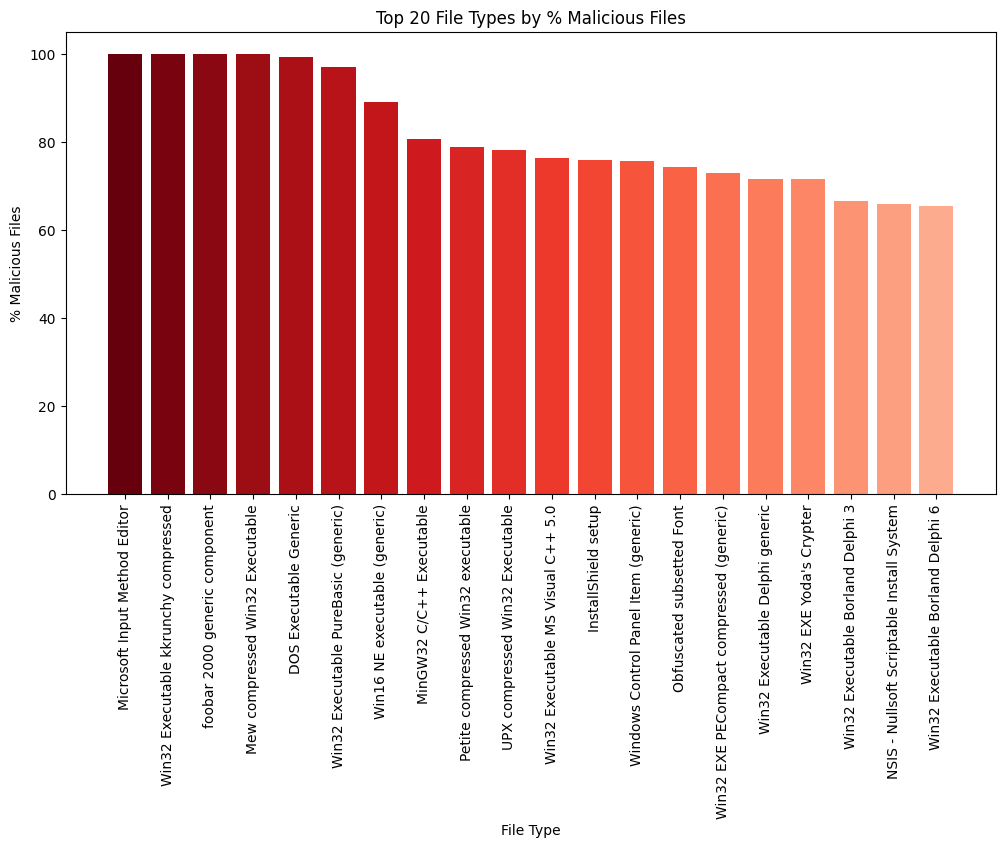

In [18]:
# Define the number of bars
num_bars = len(malicious_counts_by_file_type)

# Generate a gradient of red colors
colors = plt.cm.Reds(np.linspace(0.3, 1, num_bars))[::-1]

# Create the bar chart with colored red bars
plt.figure(figsize=(12, 6))
plt.bar(
    malicious_counts_by_file_type.index,
    malicious_counts_by_file_type["% malicious files"],
    color=colors,
)

# Customize the plot
plt.xlabel("File Type")
plt.ylabel("% Malicious Files")
plt.title("Top 20 File Types by % Malicious Files")
plt.xticks(rotation=90)

# Display the plot
plt.show()

An important conclusion we discovered from the graph is that a file whose type is one of the following: <br> 

-Microsoft Input Method Editor                         <br> 
-Win32 Executable kkrunchy compressed                  <br> 
-foobar 2000 generic component                         <br> 
-Mew compressed Win32 Executable                       <br> 


**will be 100% classified as a malicious file!**

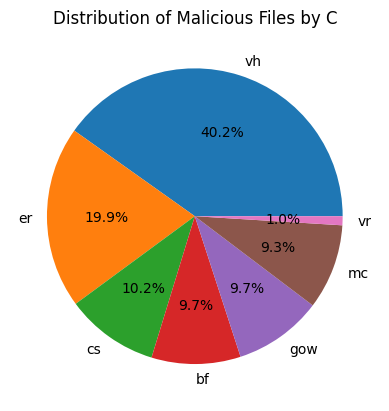

In [19]:
malicious_counts_by_C = (
    files[["C", "label"]]
    .groupby("C")
    .sum()
    .rename(columns={"label": "malicious files"})
    .sort_values(by="malicious files", ascending=False)
)

# Create a pie chart
plt.pie(
    malicious_counts_by_C["malicious files"],
    labels=malicious_counts_by_C.index,
    autopct="%1.1f%%",
)
plt.title("Distribution of Malicious Files by C")
plt.show()

It seems that files whose 'C' feature value is **vh** are likely to be malicious files.

#### <font color=white>We have finished the exploration stage.</font> <br> It is important to note that the missing values ​​have not yet been filled in at this stage **!** 

## <font color=white>Part 2 - Pre-processing</font>

**Tasks summarise:**

1. Remove irrelevant features. 
2. Mathematical manipulation of existing features.
3. Handling the missing values and Categorical features.
4. Finding and handling outliers.
5. Normalizing the data. 
6. Dimensionality Reduction. 


 **We emphasize that the pre-processing on the 'test' data will be done immediately after finishing the pre-processing on the 'train' data.**

In [20]:
files_cpy = files.copy()
test_cpy = test.copy()

files_cpy.head()

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6.80e+06,524.0,3.0,0.0,1.0,1.0,0.0,1.0,...,0.0,28.0,899075.0,13.86,Win32 EXE PECompact compressed (generic),64.2,-3.98,5.73,er,1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,4.51e+04,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,856.0,9.62,Win32 Dynamic Link Library (generic),38.4,7.06,5.74,er,0
2,b0b126adc73b980a114e38027b082d149fcf491547452f...,686136,7.05e+05,133.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,2.0,32767.0,12.14,Win64 Executable (generic),82.0,1.05,5.72,gow,0
3,ff6176c53ca9b58040c93870c264843b93b5e290c28e57...,8192,3.69e+04,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,678.0,9.55,Win64 Executable (generic),28.0,2.22,5.90,vh,1
4,59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...,396288,4.22e+05,133.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,5.0,35881.0,7.59,Win64 Executable (generic),32.2,9.40,NaN,vh,1


### <font color=white>1. Remove irrelevant features</font>

<u>We classified 3 features as irrelevant:</u> 

Feature **'sha256'** -  unique identifier for each file <br>
Feature **'has_relocations'** - There is no fundamental difference between malicious and non-malicious files<br>
Feature **'size'** - found in a relatively high correlation with additional features <br>

In [21]:
files_cpy.drop(labels=["sha256", "has_relocations", "size"], axis=1, inplace=True)

# for the prediction csv
test_index = test_cpy["sha256"]

test_cpy.drop(labels=["sha256", "has_relocations", "size"], axis=1, inplace=True)

files_cpy.head()

,vsize,imports,exports,has_debug,has_resources,has_signature,has_tls,symbols,numstrings,paths,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,6.80e+06,524.0,3.0,0.0,1.0,0.0,1.0,0.0,64882.0,0.0,...,0.0,28.0,899075.0,13.86,Win32 EXE PECompact compressed (generic),64.2,-3.98,5.73,er,1
1,4.51e+04,2.0,0.0,0.0,1.0,0.0,0.0,0.0,89.0,0.0,...,0.0,1.0,856.0,9.62,Win32 Dynamic Link Library (generic),38.4,7.06,5.74,er,0
2,7.05e+05,133.0,4.0,1.0,1.0,1.0,0.0,0.0,2699.0,0.0,...,0.0,2.0,32767.0,12.14,Win64 Executable (generic),82.0,1.05,5.72,gow,0
3,3.69e+04,6.0,0.0,0.0,0.0,0.0,0.0,NaN,71.0,0.0,...,0.0,1.0,678.0,9.55,Win64 Executable (generic),28.0,2.22,5.90,vh,1
4,4.22e+05,133.0,0.0,1.0,1.0,0.0,0.0,0.0,4729.0,0.0,...,0.0,5.0,35881.0,7.59,Win64 Executable (generic),32.2,9.40,NaN,vh,1


### <font color=white>2. Mathematical manipulation of existing features</font>

As we see the data no longer contains the unnecessary features

As we saw in the graphs, the **'log'** function makes the features clearer, so we'll change all the continuous numeric features to their log function.

In [22]:
numeric = files_cpy.select_dtypes(include=[np.number]).columns
numeric = list(numeric)
bin_col = ["has_debug", "has_tls", "has_signature", "has_resources", "label"]
for col in numeric:
    if col not in bin_col:
        files_cpy[col] = np.log1p(files_cpy[col])
        test_cpy[col] = np.log1p(test_cpy[col])

files_cpy.head()

,vsize,imports,exports,has_debug,has_resources,has_signature,has_tls,symbols,numstrings,paths,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,15.73,6.26,1.39,0.0,1.0,0.0,1.0,0.0,11.08,0.0,...,0.0,3.37,13.71,2.70,Win32 EXE PECompact compressed (generic),4.18,NaN,1.91,er,1
1,10.72,1.10,0.00,0.0,1.0,0.0,0.0,0.0,4.50,0.0,...,0.0,0.69,6.75,2.36,Win32 Dynamic Link Library (generic),3.67,2.09,1.91,er,0
2,13.47,4.90,1.61,1.0,1.0,1.0,0.0,0.0,7.90,0.0,...,0.0,1.10,10.40,2.58,Win64 Executable (generic),4.42,0.72,1.91,gow,0
3,10.52,1.95,0.00,0.0,0.0,0.0,0.0,NaN,4.28,0.0,...,0.0,0.69,6.52,2.36,Win64 Executable (generic),3.37,1.17,1.93,vh,1
4,12.95,4.90,0.00,1.0,1.0,0.0,0.0,0.0,8.46,0.0,...,0.0,1.79,10.49,2.15,Win64 Executable (generic),3.50,2.34,NaN,vh,1


Before applying any changes to the train data, **we decided to leave out 10% of it**, so we can validate our models in a "test-like" manner. <br>
Any changes that might be applied to our validation/simulated test data would be exactly the same as they should be on the real test data later on.

In [23]:
train_cpy, validation_cpy, y_train, y_validation = train_test_split(
    files_cpy.drop("label", axis=1),
    files_cpy["label"],
    test_size=0.1,
    random_state=42,
    shuffle=True,
)
train_cpy.shape, y_train.shape, validation_cpy.shape, y_validation.shape

((54000, 20), (54000,), (6000, 20), (6000,))

### <font color=white>3. Handling the missing values and Handle Categorical features.</font>

Function that helps us to check if our switch work :

In [24]:
def count_string_values(dataframe, column_name):
    count = 0
    str_list = []
    for value in dataframe[column_name]:
        if isinstance(value, str):
            count += 1
            str_list.append(value)
    return count, str_list

Function for filling in the nan values in all the **categorical columns**  ​​with the **median value** of each column :

At the beginning of the function, we converted the categorial values ​​to numbers in an serial way.
To begin with, we found no reason to use dummies for each category because this simplicity would have cost us by increasing the dimensionality significantly the addition of 94 new columns (88+6=94) and therefore we decided to give each value in a certain feature a serial number from the smallest to the largest so that the value that received the number the shortest sichdori is the most common among the other values ​​and so on.
Thus, we were left with a dimension of a reasonable size, when later additional dimension reduction methods even improved the performance significantly.

Too much dimensionality of a problem may mislead us into overfitting because the model will be over-fitted to the data set and we will pay for it with a very high variance in the model's performance on the test set.
We can usually detect a large dimensionality by a longer than expected running time. <br> The wisdom and greatness is to find the right balance because the information and beauty is found in the features themselves that provide us with the excellent performance, but overuse of them will result in a significant devaluation of the performance later on.

In [25]:
def fill_na_value_counts(df_train, df_val, df_test, column):
    """
    Returns data frame after we fulfill nan values
    df: data frame, which we fill in nan values
    column: string, the column in the data frame where the nan values are filled
    """
    dict1 = df_train[column].value_counts().to_dict()
    for i, key in enumerate(dict1):
        dict1[key] = i + 1
    # Filling for train data
    df_train[column] = df_train[column].replace(dict1)
    df_train.loc[df_train[column].isnull(), column] = df_train.loc[
        df_train[column].isnull(), column
    ].fillna(df_train[column].median())
    # Filling for validation data
    df_val[column] = df_val[column].replace(dict1)
    df_val.loc[df_val[column].isnull(), column] = df_val.loc[
        df_val[column].isnull(), column
    ].fillna(df_train[column].median())
    # Filling for test data
    df_test[column] = df_test[column].replace(dict1)
    df_test.loc[df_test[column].isnull(), column] = df_test.loc[
        df_test[column].isnull(), column
    ].fillna(df_train[column].median())

<u>We chose to handle nan values ​​in this way for the following reason:</u><br>

Arbitrarily we wanted to give each column its median value, we thought this would give a proper balance.  With the help of validation of the results, we saw that the median provides better performance and we decided to stay with it.


In [26]:
# Impliment of 'fill_na_value_counts' function that replace string values of categorical columns to numbers values by ascending order and fill them with the median.

fill_na_value_counts(train_cpy, validation_cpy, test_cpy, "C")

string_count, string_list_train = count_string_values(train_cpy, "C")
print(f"The number of string values in train data at column 'C' is: {string_count}")

string_count, string_list_validation = count_string_values(validation_cpy, "C")
print(
    f"The number of string values in validation data at column 'C' is: {string_count}"
)

string_count, string_list_test = count_string_values(test_cpy, "C")
print(f"The number of string values in test data at column 'C' is: {string_count}")

The number of string values in train data at column 'C' is: 0
The number of string values in validation data at column 'C' is: 0
The number of string values in test data at column 'C' is: 0


In [27]:
fill_na_value_counts(train_cpy, validation_cpy, test_cpy, "file_type_trid")

string_count, string_list_train = count_string_values(train_cpy, "file_type_trid")
print(
    f"The number of string values in train data at column 'file_type_trid' is: {string_count}"
)

string_count, string_list_validation = count_string_values(
    validation_cpy, "file_type_trid"
)
print(
    f"The number of string values in validation data at column 'file_type_trid' is: {string_count}"
)

string_count, string_list_test = count_string_values(test_cpy, "file_type_trid")
print(
    f"The number of string values in test data at column 'file_type_trid' is: {string_count}"
)

The number of string values in train data at column 'file_type_trid' is: 0
The number of string values in validation data at column 'file_type_trid' is: 0
The number of string values in test data at column 'file_type_trid' is: 2


<u>We've run into a problem:</u> <br>
The number of string values in test data at column 'file_type_trid' is: '2'.  
 

The reason we didn't get '0' after filling in the missing values of feature 'file_type_trid' ​​in the 'test data' is that apparently, there were file types that didn't appear in the 'train data':


<u>The solution we will offer is :</u> we will turn them to '0' (before we turned the rest of the categorical feature values ​​to 1-89 according to their frequency, so this seems logical :

In [28]:
# handle this problem
for file_type in string_list_test:
    test_cpy["file_type_trid"][test_cpy["file_type_trid"] == file_type] = 0

Let's make sure we fix the problem :

In [29]:
string_count, string_list_test = count_string_values(test_cpy, "file_type_trid")
print(
    f"The number of string values in test data at column 'file_type_trid' is: {string_count}"
)

The number of string values in test data at column 'file_type_trid' is: 0


Function for filling nan values in all the **binary (without label) columns** ​with the **common value** in them :

In [30]:
def fill_na_binary_columns(df_train, df_val, df_test, column):
    """
    Returns data frame after we fulfill nan values
    df: data frame, which we fill in nan values
    column: string, the column in the data frame where the nan values are filled
    """
    common_value = 1
    df_train.loc[df_train[column].isnull(), column] = df_train.loc[
        df_train[column].isnull(), column
    ].fillna(common_value)
    df_test.loc[df_test[column].isnull(), column] = df_test.loc[
        df_test[column].isnull(), column
    ].fillna(common_value)
    df_val.loc[df_val[column].isnull(), column] = df_val.loc[
        df_val[column].isnull(), column
    ].fillna(common_value)

<u>We chose to handle member values ​​in this way for the following reason:</u><br>

In the exploration stage, we showed with the help of visualization of our binary columns that there is a significantly greater amount of '1' than '0' and therefore logically, we will fill the missing values ​​with the common value in them: '1' so that this will not harm the balance between them.

In [31]:
# Impliment of 'fill_na_binary_columns' function
bin_col = ["has_debug", "has_tls", "has_signature", "has_resources"]
for col in bin_col:
    fill_na_binary_columns(train_cpy, validation_cpy, test_cpy, col)

Fill nan values of **numeric continues columns** with **KNNImputer model** that fill based on the nan value neighbors. <br> 
Here's an overview of how the KNNImputer works:

<u>Identify missing values:</u> The KNNImputer examines the input dataset and identifies the missing values, represented as NaN.<br>
<u>Finding nearest neighbors:</u> For each missing value, the KNNImputer locates the k-nearest neighbors in the feature space based on the available non-missing values. The number of neighbors, k = squre root of n_sampels (we read that a good start point), is specified by the n_neighbors parameter.<br>
<u>Computing imputed values:</u> Once the nearest neighbors are identified, the KNNImputer calculates the imputed value for the missing entry based on the mean of the available values of the neighbors.<br>
<u>Repeating the process:</u> The imputation process is repeated for all missing values in the dataset until all missing entries have been filled.<br>
<u>Output:</u> The KNNImputer returns a new dataset with the missing values replaced by the imputed values.<br>

#### **We used this tool that is not taught in the course :**

In [32]:
# Initialize KNNImputer with the desired number of neighbors
imputer = KNNImputer(n_neighbors=int(math.sqrt(train_cpy.shape[0])))

# Perform KNN imputation
X_train_imputed = imputer.fit_transform(train_cpy)
X_validation_imputed = imputer.transform(validation_cpy)
X_test_imputed = imputer.transform(test_cpy)

# Convert the imputed array back to a DataFrame
train_cpy_imputed = pd.DataFrame(X_train_imputed, columns=train_cpy.columns)
validation_cpy_imputed = pd.DataFrame(
    X_validation_imputed, columns=validation_cpy.columns
)
test_cpy_imputed = pd.DataFrame(X_test_imputed, columns=test_cpy.columns)

# Concatenate the imputed DataFrame with the target column
train_cpy_imputed["label"] = y_train.values
validation_cpy_imputed["label"] = y_validation.values

train_cpy_imputed.isna().sum(), validation_cpy_imputed.isna().sum(), test_cpy_imputed.isna().sum()

(vsize                  0
 imports                0
 exports                0
 has_debug              0
 has_resources          0
 has_signature          0
 has_tls                0
 symbols                0
 numstrings             0
 paths                  0
 urls                   0
 registry               0
 MZ                     0
 printables             0
 avlength               0
 file_type_trid         0
 file_type_prob_trid    0
 A                      0
 B                      0
 C                      0
 label                  0
 dtype: int64,
 vsize                  0
 imports                0
 exports                0
 has_debug              0
 has_resources          0
 has_signature          0
 has_tls                0
 symbols                0
 numstrings             0
 paths                  0
 urls                   0
 registry               0
 MZ                     0
 printables             0
 avlength               0
 file_type_trid         0
 file_type_prob_trid   

Yess it's work! there no nan values in the 'train' data, 'validation' data and the 'test' data.

###  <font color=white>4. Finding and handling outliers</font>

Based on the distribution we saw at the beginning, We wil treat outliers only for relevant features, **numeric continues features**. Binary features whose value is 0 or 1 and categorial features are not relevant.
 Let's visualize the outliers in those features with Boxplot:

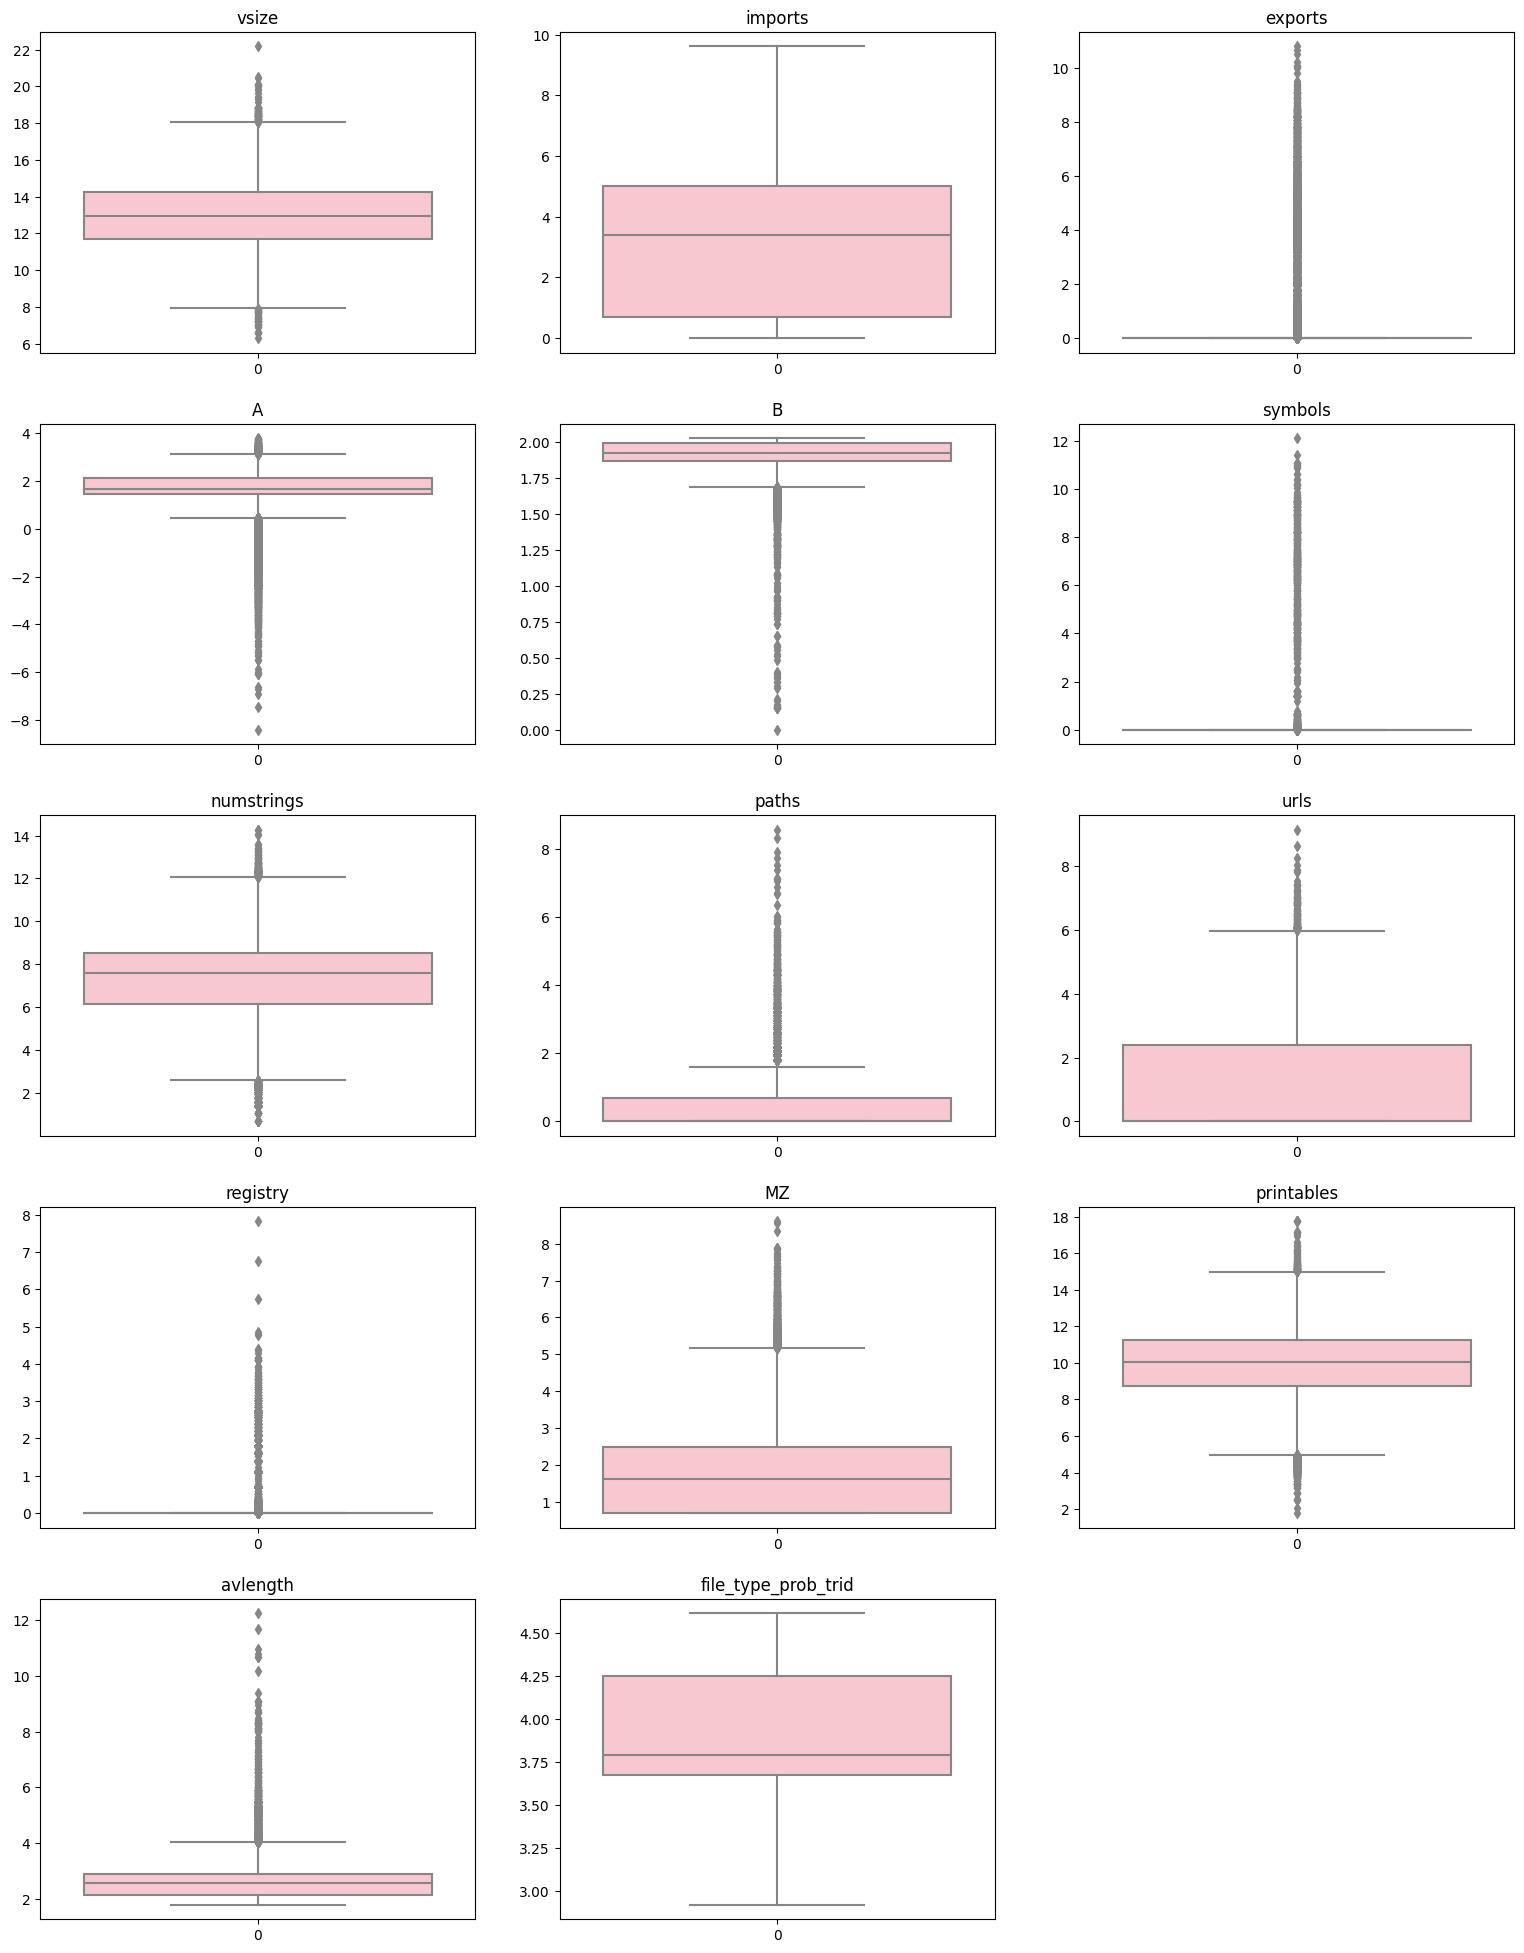

In [33]:
def box_plot(df):
    columns = [
        "vsize",
        "imports",
        "exports",
        "A",
        "B",
        "symbols",
        "numstrings",
        "paths",
        "urls",
        "registry",
        "MZ",
        "printables",
        "avlength",
        "file_type_prob_trid",
    ]
    num_columns = len(columns)
    rows = (num_columns - 1) // 3 + 1

    fig, axes = plt.subplots(rows, 3, figsize=(16, 4 * rows))
    plt.tight_layout(pad=3)

    for i, column in enumerate(columns):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        sns.boxplot(df[column], color="pink", ax=ax).set_title(column)

    # Remove the empty subplot
    fig.delaxes(axes[4, 2])

    plt.show()


box_plot(train_cpy_imputed)

Outliers will be cut using the interquartile range (IQR) method, which involves deleting values ​​that have a higher value than the 95% precentile of each feature or a lower value than the 5% precentile of each feature. <br>

**<u>The reason we specifically chose these percentile values ​​for the upper and lower limits :</u>**<br> 
first of all, we started from the assumption that variation is important and we did not want to deal with too many such values. Throughout the project we went back and forth and changed the percentile values ​​that would cut the extreme values ​​between the model results. We discovered that the model brings better results when the percentile for the upper bound is indeed very high - 95% and the percentile for the lower bound is very low respectively - the complement of the upper bound is 5%.


 By doing this, we can reduce noise in the data.

<u>Let's look at the graphs and identify that : </u>
1. The features: **file_type_prob_trid**, **imports** has no unusual values, so we will **ignore it**. <br>
2. The feature: **B**, has missing values ​**​below the lower_bound**. <br>
3. The features: **paths**, **urls**, **MZ**, **avlength**,**symbols**, **exports**, **registry** has missing values **​​above the upper_bound**. <br>
4. The features: **A**, **vsize**, **numstrings**, **printables** has missing values ​​on **both sides of the bounds**. <br>


Therefore, we will handle them accordingly:

In [34]:
def remove_outliers(df):
    columns_d = {
        "vsize": "both",
        "A": "both",
        "B": "lower",
        "numstrings": "both",
        "paths": "upper",
        "urls": "upper",
        "MZ": "upper",
        "printables": "both",
        "avlength": "upper",
        "exports": "upper",
        "symbols": "upper",
        "registry": "upper",
    }

    # Create a copy of the DataFrame to avoid modifying the original data
    df_cleaned = df.copy()

    # Iterate over each column in the DataFrame
    for column in columns_d:
        q1 = df_cleaned[column].quantile(0.05)
        q3 = df_cleaned[column].quantile(0.95)
        iqr = q3 - q1

        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        if columns_d[column] == "lower":
            outliers = df_cleaned[column] < lower_bound
        elif columns_d[column] == "both":
            outliers = (df_cleaned[column] < lower_bound) | (
                df_cleaned[column] > upper_bound
            )
        else:
            outliers = df_cleaned[column] > upper_bound

        num_outliers = outliers.sum()
        df_cleaned.drop(df_cleaned[outliers].index, inplace=True)
        print(f"Num of outliers removed for column '{column}': {num_outliers}")

    return df_cleaned


train_cpy_imputed = remove_outliers(train_cpy_imputed)

Num of outliers removed for column 'vsize': 0
Num of outliers removed for column 'A': 36
Num of outliers removed for column 'B': 149
Num of outliers removed for column 'numstrings': 0
Num of outliers removed for column 'paths': 280
Num of outliers removed for column 'urls': 0
Num of outliers removed for column 'MZ': 0
Num of outliers removed for column 'printables': 0
Num of outliers removed for column 'avlength': 76
Num of outliers removed for column 'exports': 653
Num of outliers removed for column 'symbols': 1349
Num of outliers removed for column 'registry': 2274


It seems that the 2 features: **'symbols'** and **registry'** had the most unusual values ​​and **will not contribute significantly to our model.**

We removed a total of 4,820 examples out of 60,000. <br> That is, about **8% of the data set was dropped**, so in our opinion it is not too much and we can stand it.

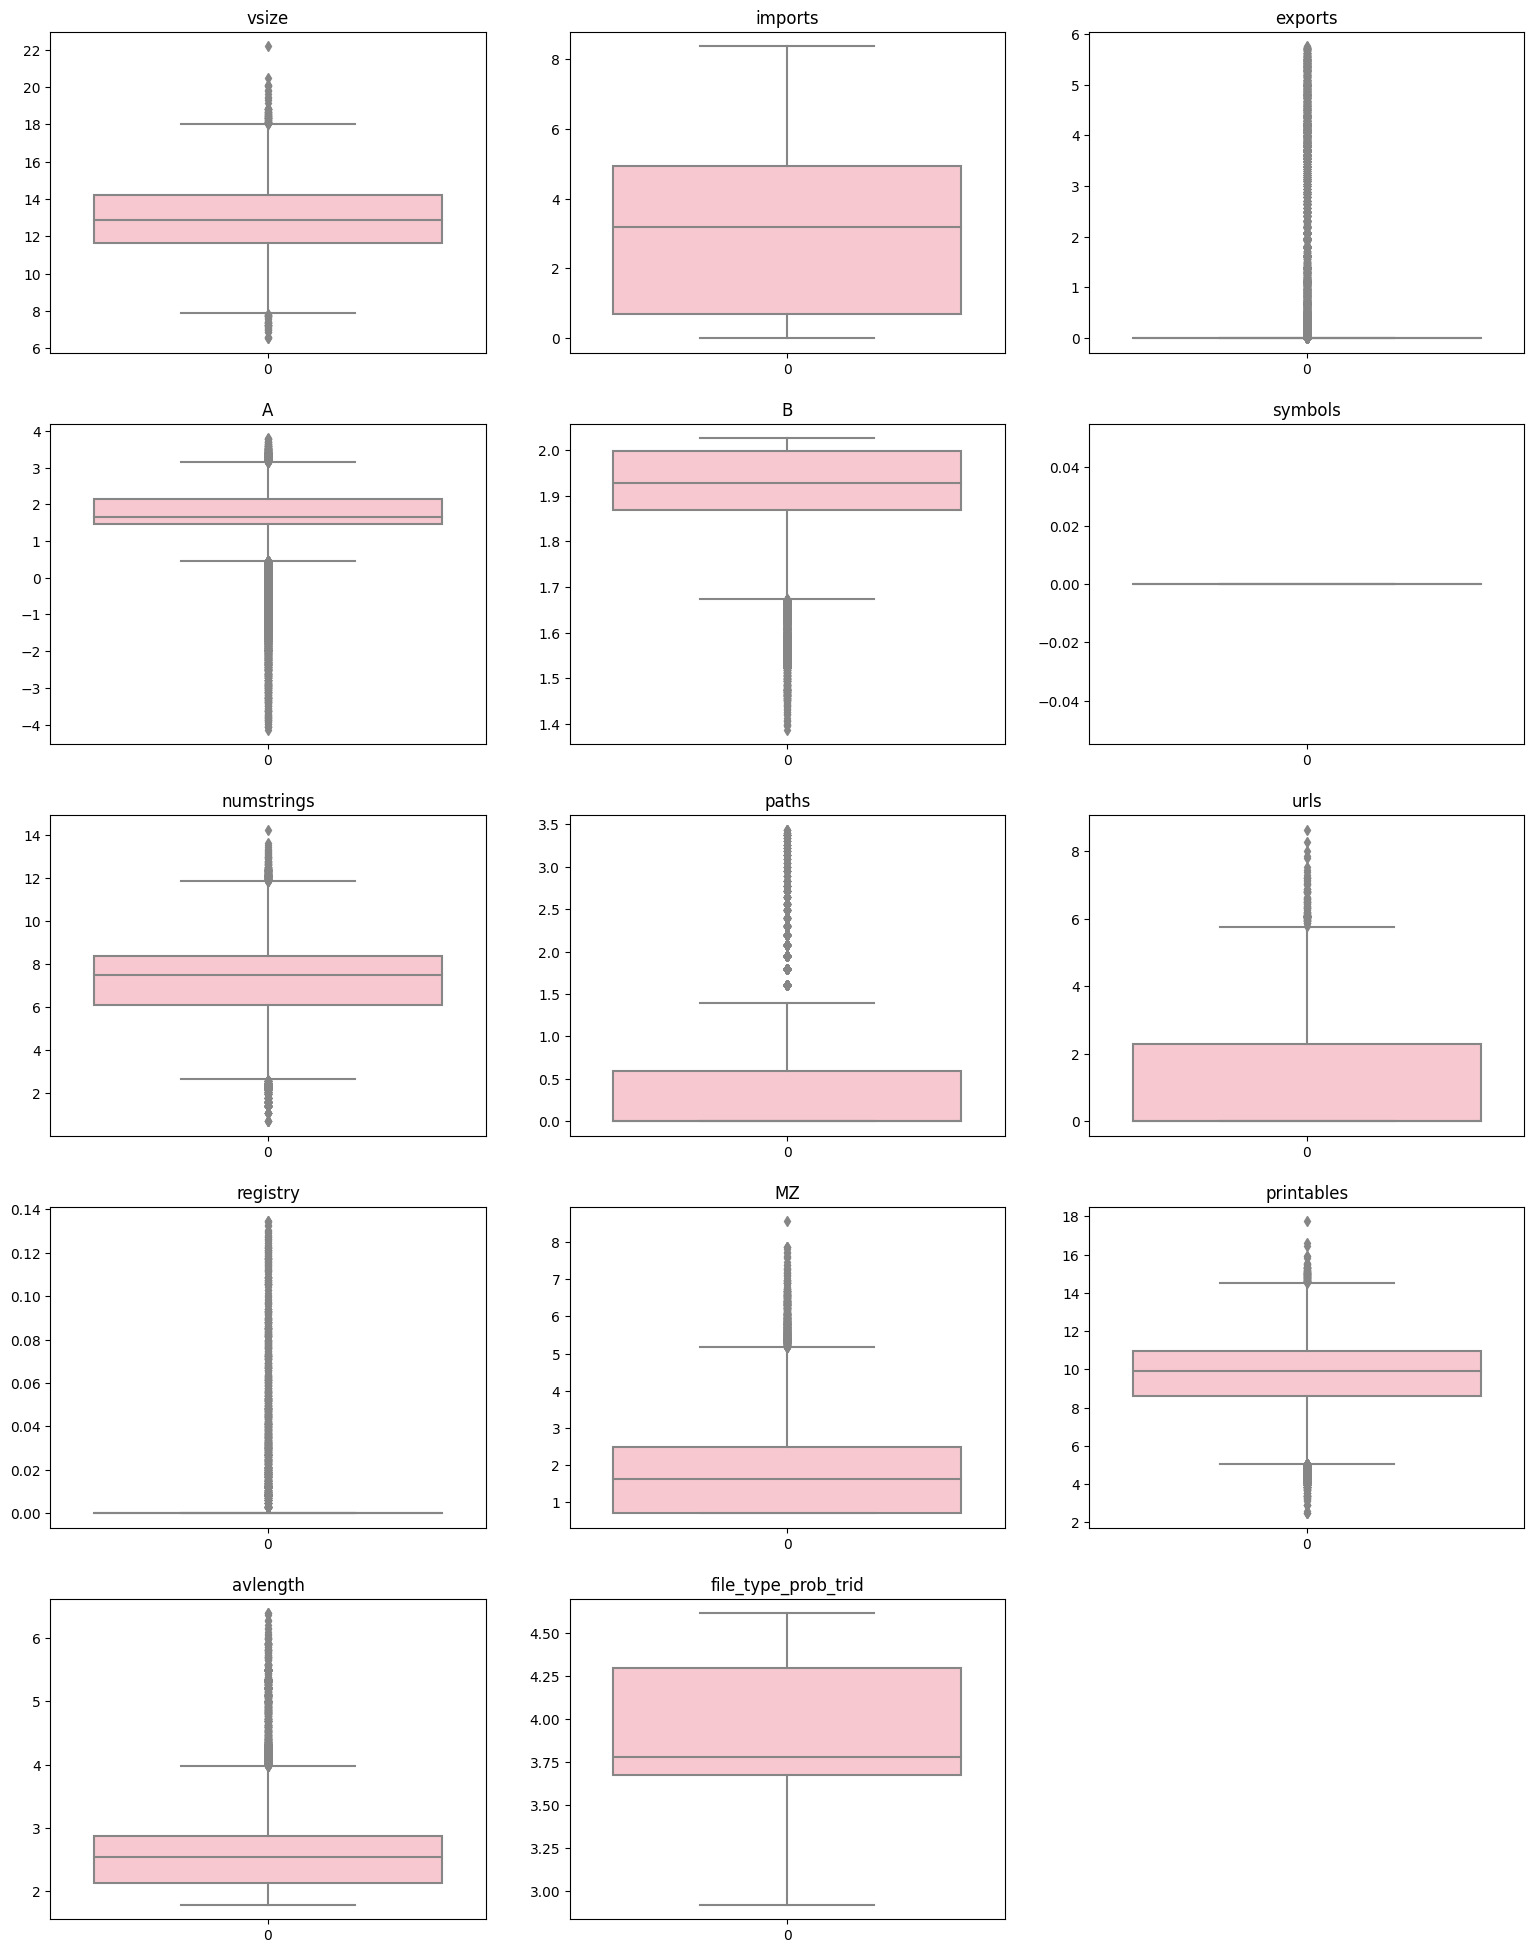

In [35]:
box_plot(train_cpy_imputed)

It can be seen that we were indeed able to delete values ​​that we found to be outliers by the median for two reasons that are visible in the graphs:

1. **The density of the points increased**.
2. **The range of values ​​in which the examples are found decreased**.

<u>For example</u>, let's look at the feature **paths**, it seems that its range of values ​​was initially about 2-9 and decreased to 1.5-3.5. In addition, we see that the density of points has increased.

<u>In addition to this</u>, we will notice the change that happened after the removal of outliers from the **'symbols'** feature: <br>
It seems that there were many unusual values ​​that were removed and currently all of its values ​​are 0. This indicates that this feature will not contribute to our model in the future and we will probably see this later by running the feature importance.

### <font color=white>5. Normalizing the data</font>

Later, we will run various tools that require normalized data (e.g. PCA). <br>
Because the distribution of most features has a different scale, it should be normalized. 

We saw by the distribution of the features that some of them do resemble a normal distribution, therefore we will use **'StandardScaler'**. <br> 
By doing so, all features will have an expectation of 0 and a variance of 1.

In [36]:
X_train, y_train = train_cpy_imputed.values[:, :-1], train_cpy_imputed.values[:, -1]
y_train = y_train.astype("int")

X_validation, y_validation = validation_cpy_imputed.values[:, :-1], validation_cpy_imputed.values[:, -1]

y_validation = y_validation.astype("int")

X_test = test_cpy_imputed.values

In [37]:
#scaler= MinMaxScaler() This is an unsuccessful attempt and has no place in the final work flow.
scaler = StandardScaler()
X_scalar = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)
X_scalar, X_validation, X_test

(array([[-0.88252982, -1.12855512, -0.33110927, ..., -0.02458987,
         -0.39948744, -0.90966919],
        [ 0.83683199,  2.00702442,  0.52272799, ...,  1.32511243,
         -0.03617043, -0.33285186],
        [ 0.19351189, -0.05995896, -0.33110927, ..., -4.03230158,
         -0.32882009, -0.90966919],
        ...,
        [ 0.94543288, -0.94965844, -0.33110927, ...,  1.19352959,
          1.11592497,  1.39760015],
        [ 0.93731146, -0.36933636, -0.33110927, ..., -0.01828018,
          1.11378426,  1.39760015],
        [ 0.94543288, -0.94965844, -0.33110927, ...,  0.07665221,
          1.1158276 ,  0.24396548]]),
 array([[ 0.11131984,  0.59538895,  5.2913771 , ...,  0.4558094 ,
          0.4487693 , -0.90966919],
        [ 1.19921985,  1.28896569, -0.33110927, ..., -0.03517772,
          0.59672308,  1.97441749],
        [-1.3421866 , -1.14509504, -0.33110927, ..., -1.79024151,
          0.24729726,  1.39760015],
        ...,
        [ 0.52497616,  1.00472119, -0.33110927, ...,  

### <font color=white>6. Dimensionality Reduction</font>

As we mentioned earlier, large dimensionality can create a problem during computation. When the dimension of the problem is large there is a high variance which will result to low bias and therefore to overfitting.
The dimension of our problem is dependent on the complexity of the model. For a complex model we do not want to reduce dimensionality because it only hurts the running time,and there is no risk to overfitting. On the other hand, in a simple model, an overfitting problem may arise, so we would like to reduce the dimensions there. For example in logistic regression(low complexity), we do lower the dimensions, however in the random forest(high complexity) model the dimension of our problem does not change and therefore we do not lower the dimensions there.

As of now, we are left with **20 features** out of the 23 we started with, and therefore the size of the problem is still considered **high** and we would like to lower it. <br>

We will reduce dimensions in two ways:
- PCA
- Forward Selection

 we will compare them and choose the one whose performance will be better in the next stage.

 **The functions:**

- **PCA**

In [38]:
def get_principal_components(X: np.array, p: float) -> np.array:
    """
    Returns array of principal components explaining (100*p)% of the variance
    X: 2d numpy array of data we want to apply PCA on.
    p: float in the range (0,1]. The proportion of variance explained by components
    """
    my_model = PCA(n_components=p)
    my_model.fit(X)
    return my_model.components_

- **Forward Selection**

In [39]:
def get_sigma_hat_squared(X: np.array, y: np.array, model) -> float:
    """
    Returns sigma_hat squared - an estimate of the noise variance sigma
    X: 2d np.array with the data.
    y: labels
    """
    model.fit(X, y)
    RSS = mean_squared_error(y, model.predict(X)) * X.shape[0]
    return RSS / (X.shape[0] - X.shape[1] - 1)


def get_mallows_cp_score(
    X: np.array, y: np.array, sigma_hat_squared: float, model
) -> float:
    """
    Returns mallow cp score for given data, selected features and train model.
    X: 2d numpy array of data with only selected features
    y: 1d numpy array of labels (also knows as target values)
    sigma_hat_squared: the estimate for noise variance
    """
    model.fit(X, y)
    MSE = mean_squared_error(y, model.predict(X))
    return MSE + (2 * (X.shape[1] + 1) * sigma_hat_squared) / X.shape[0]


def add_feature(X: np.array, y: np.array, current_features, sigma_hat_squared, model):
    """
    Returns dictionary with list of features including chosen feature to include and the score with selected feature
    X: 2d np array with all the features.
    y: 1d np array with the labels
    current_features: list of indexes which represent the features which are already included
    sigma_hat_squared: the estimate for noise variance
    returns: A dictionary with 2 keys:
            'features': a sorted list of indexes containing the features of the best model (with the additional feature) -> current_features + [added feature]
            'score': the mallows cp score of that model
    """
    dict1 = {}
    for x in range(X.shape[1]):
        added_features_list = current_features[:]
        if x not in current_features:
            added_features_list.append(x)
            cp_score = get_mallows_cp_score(
                X[:, added_features_list], y, sigma_hat_squared, model
            )
            dict1[cp_score] = added_features_list
    return {"features": sorted(dict1[min(dict1.keys())]), "score": min(dict1.keys())}


def forward_selection(X: np.array, y: np.array, model):
    """
    returns list of indexes for the selected features
    X: 2d numpy array with original training data
    y: numpy vector with targets of training data
    returns: a sorted list containing the indexes of the selected features
    """
    num_of_features = X.shape[1]
    current_features = []
    # Calculate error on model with all features
    sigma_hat_squared = get_sigma_hat_squared(X, y, model)

    models_lst = []
    for i in range(num_of_features):
        res = add_feature(X, y, current_features, sigma_hat_squared, model)
        models_lst.append(res)
        current_features = models_lst[-1]["features"]

    # Plotting
    scores_lst = [x["score"] for x in models_lst]
    plt.plot(range(1, len(scores_lst) + 1), scores_lst)
    plt.xlabel("number of features")
    plt.ylabel("mallows cp")
    plt.title("mallows Cp score VS number of features")
    plt.show()

    # Returning features of best model, based on mallows cp score
    best_model = min(models_lst, key=lambda x: x["score"])
    best_features = best_model["features"]
    return sorted(best_features)

### <font color=white>Reusable Functions for all the models:</font>

**Choose PCA or Forward Selection**

In [40]:
def choose_PCA_or_forward_selection(
    x_forward_reduced_train, x_pca_reduced, y_train, model_forward_selection, model_PCA
):
    """
    Returns an array,if the PCA MSE is lower than the forwrad selection MSE, it returns array of principal components explaining (100*p)% of the variance dot train data,
    else,it returns the train data after lowering dimensions that the forward selection does.
    x: 2d np train data reduced.
    model_forward_selection: the model we worked with in forward selection
    model_PCA: the model we worked with in PCA
    """
    model_forward_selection.fit(x_forward_reduced_train, y_train)
    model_PCA.fit(x_pca_reduced, y_train)

    train_mse_forward = mean_squared_error(
        y_train, model_forward_selection.predict(x_forward_reduced_train)
    )
    train_mse_pca = mean_squared_error(y_train, model_PCA.predict(x_pca_reduced))

    print(f"MSE train - PCA: {round(train_mse_pca,6)}")
    print(f"MSE train - forward: {round(train_mse_forward,6)}")
    if train_mse_pca < train_mse_forward:
        return x_pca_reduced
    else:
        return x_forward_reduced_train

**plot Roc KFold**

In [41]:
# The function does classification and ROC analysis, Run classifier with cross-validation and plot ROC curves


def plot_roc_kfold(clf, cv, X, y, giventitle):
    # Plot roc curve for each k of the folds given in the cv argument
    # Returns the mean tpr and fpr for comparison purposes
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10, 7))
    for i, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            clf,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.3f $\pm$ %0.4f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=giventitle,
    )

    ax.legend(loc="lower right")
    plt.show()

    return mean_tpr, mean_fpr

# <font color=white>Part 3+4: Running the Models and choose dimension reduce method + Evaluation of the Models </font>

**Several preparations before running the models :**

Implement PCA :

In [42]:
components_PCA = get_principal_components(X_scalar, 0.99)
print(
    f"number of components which preserve at least 99% of the variance: {len(components_PCA)}"
)
x_pca_reduced = np.dot(X_scalar, components_PCA.T)

number of components which preserve at least 99% of the variance: 17


In [43]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [44]:
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 8


## <font color=white> Basic Models</font>

### **<font color=white>Logistic Regression</font>**
A linear model that classifies discrete classes based on the fitted weights.

Implement forward selection :

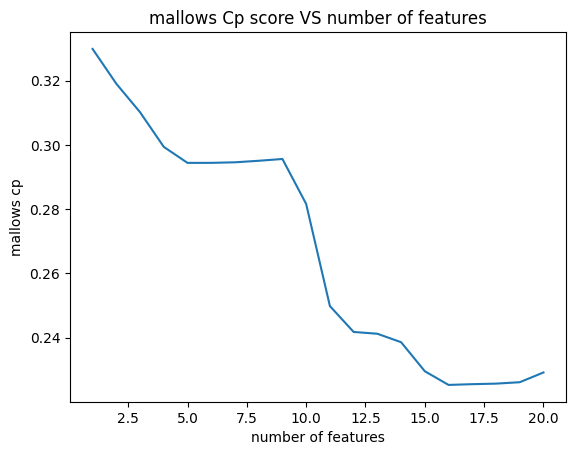

number of selected features by forward selection: 16


In [45]:
components_fs = forward_selection(X_scalar, y_train, LogisticRegression())
print(f"number of selected features by forward selection: {len(components_fs)}")
x_fs_reduced_lr = X_scalar[:, components_fs]

Now that we have reduced dimensions by the 2 options, we will choose which one has a **lower MSE error** and we will use it for our model :

In [46]:
x_best_dimension_reduced_lr = choose_PCA_or_forward_selection(
    x_fs_reduced_lr, x_pca_reduced, y_train, LogisticRegression(), LogisticRegression()
)

MSE train - PCA: 0.223207
MSE train - forward: 0.225098


It can be seen that **PCA was chosen** for the purpose of reducing the dimensions of the logistic regression problem.

In order to be certain about the picks of hyper-parameters, we grid-search for the best ones with the features that were selected:

In [47]:
parameters = {
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "solver": ["saga", "newton-cg", "lbfgs", "liblinear", "sag"],
    "max_iter": [50, 100, 150],
    "fit_intercept": [True, False],
    "C": [0.001, 0.01, 0.1, 1],
}
lr = LogisticRegression(random_state=42)
gscv_lr = GridSearchCV(lr, parameters, scoring="roc_auc", cv=cv, n_jobs=(n_cpu - 1))
gscv_lr.fit(x_best_dimension_reduced_lr, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=LogisticRegression(random_state=42), n_jobs=7,
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['saga', 'newton-cg', 'lbfgs', 'liblinear',
                                    'sag']},
             scoring='roc_auc')

The Hyper-parameters of our final Logistic Regression model are:

In [48]:
best_params_lr_final = gscv_lr.best_params_
print(f"Best Params: {best_params_lr_final} \n")

Best Params: {'C': 0.001, 'fit_intercept': False, 'max_iter': 50, 'penalty': 'none', 'solver': 'saga'} 



Logistic Regression model with the best parameters:

In [49]:
lr_best_estimator = gscv_lr.best_estimator_

Plot that presents the ROC curve for each fold in our cross-validation and the mean score for all of them in the dark blue. <br>
Seems like a consistent and solid results over many different splits.

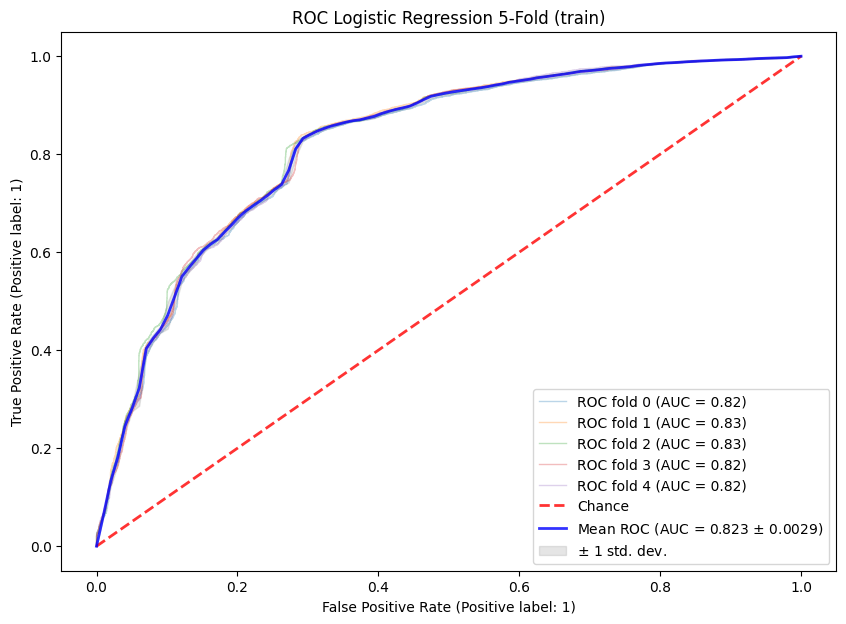

In [50]:
mean_tpr_lr, mean_fpr_lr = plot_roc_kfold(
    lr_best_estimator,
    cv,
    x_best_dimension_reduced_lr,
    y_train,
    "ROC Logistic Regression 5-Fold (train)",
)

Looks like the standard deviation between the folds is very low - another indicator for the model not being overly fitted to just one dataset.

Let's check on simulated test data : <br>

Sanity check to make sure we don't suffer from overfitting even after the dimension reduction.

In [51]:
x_validation_pca_reduced_lr = np.dot(X_validation, components_PCA.T)

auc_score = roc_auc_score(
    y_validation, lr_best_estimator.predict_proba(x_validation_pca_reduced_lr)[:, 1]
)
print("ROC AUC score of our simulated 'TEST' set: " + str(auc_score))

ROC AUC score of our simulated 'TEST' set: 0.8164693968436828


We will be in 'over fitting' when the mean roc auc of the train will be much higher than the mean roc auc of the validation. 
 
A comparison between the two:
- Mean ROC AUC train = 0.823
- ROC AUC validation = 0.816

Looks great and removes any suspicion about overfitting. <br>
We believe this might be the right balance of bias and variance.

### <font color=white>**Naïve Bayes Classifier** </font>

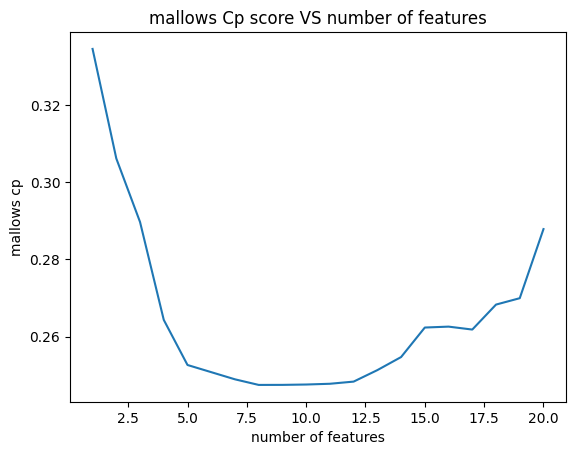

number of selected features by forward selection: 8


In [52]:
components_gnb = forward_selection(X_scalar, y_train, GaussianNB())
print(f"number of selected features by forward selection: {len(components_gnb)}")
x_fs_reduced_gnb = X_scalar[:, components_gnb]

In [53]:
x_best_dimension_reduced_gnb = choose_PCA_or_forward_selection(
    x_fs_reduced_gnb, x_pca_reduced, y_train, GaussianNB(), GaussianNB()
)

MSE train - PCA: 0.261127
MSE train - forward: 0.247362


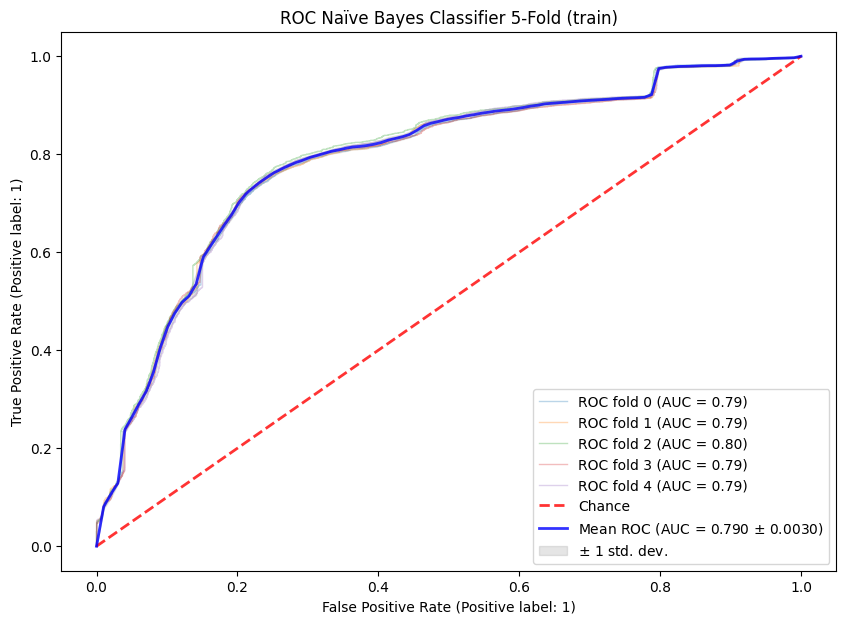

In [54]:
gnb_model = GaussianNB()
mean_tpr_gnb, mean_fpr_gnb = plot_roc_kfold(
    gnb_model,
    cv,
    x_best_dimension_reduced_gnb,
    y_train,
    "ROC Naïve Bayes Classifier 5-Fold (train)",
)

Let's check on simulated test data :

In [55]:
x_validation_fs_reduced_gnb = X_validation[:, components_gnb]

auc_score = roc_auc_score(
    y_validation, gnb_model.predict_proba(x_validation_fs_reduced_gnb)[:, 1]
)
print("ROC AUC score of our simulated 'TEST' set: " + str(auc_score))

ROC AUC score of our simulated 'TEST' set: 0.7975955393064067


Sanity check to make sure we don't suffer from overfitting even after the dimension reduction:

- Mean ROC AUC train = 0.790
- ROC AUC validation = 0.797

The difference between the two is minimal, so there is no over fitting!

## <font color=white> Advanced Models<font>

The following two models are complex, so there is no need to reduce dimensions for them.

### <font color=white> **Multi-Layer Perceptron (ANN)**</font>

The GridSearchCV function helps us decide what combination of hyper-parameters will be the best for the model, while cross validating. 

There is a Bias-Variance tradeoff to be considered when selecting the Hyper-parameters such as hidden layers size. We will try to avoid high variance by limiting the size up to 70 and selecting the best value underneath.

In [56]:
parameters = {
    "hidden_layer_sizes": [30, 50, 70],
    "learning_rate_init": [0.01, 0.001, 0.0001],
    "learning_rate": ["adaptive"],
    "alpha": [0.001, 0.01],
    "activation": ["logistic", "relu"],
    "solver": ["adam"],
}
mlp = MLPClassifier(random_state=42)
gscv_mlp = GridSearchCV(mlp, parameters, scoring="roc_auc", cv=cv, n_jobs=(n_cpu - 1))
gscv_mlp.fit(X_scalar, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=MLPClassifier(random_state=42), n_jobs=7,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.001, 0.01],
                         'hidden_layer_sizes': [30, 50, 70],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.01, 0.001, 0.0001],
                         'solver': ['adam']},
             scoring='roc_auc')

In [57]:
best_params_mlp_final = gscv_mlp.best_params_
print(f"Best Params: {best_params_mlp_final} \n")

Best Params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 70, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'adam'} 



In [58]:
mlp_best_estimator = gscv_mlp.best_estimator_

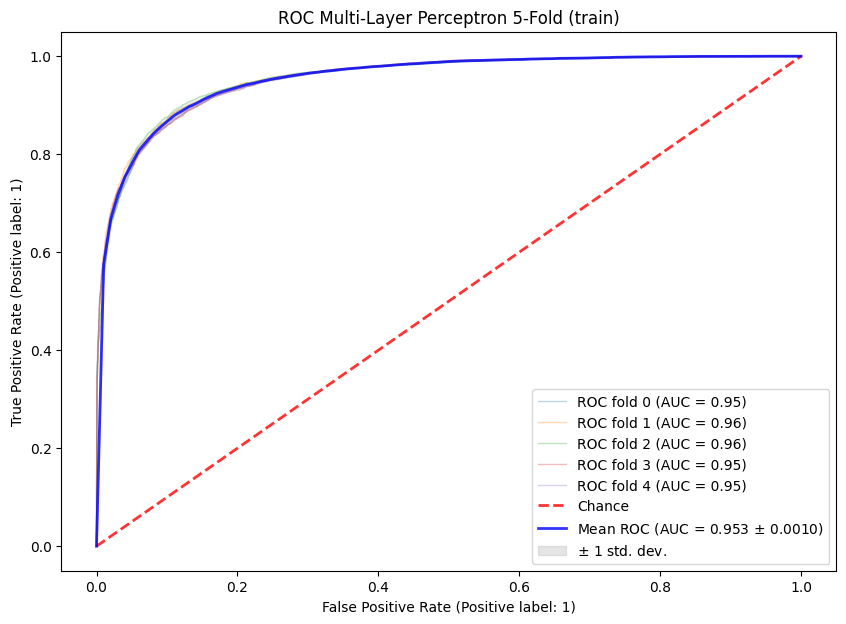

In [59]:
mean_tpr_mlp, mean_fpr_mlp = plot_roc_kfold(
    mlp_best_estimator,
    cv,
    X_scalar,
    y_train,
    "ROC Multi-Layer Perceptron 5-Fold (train)",
)

Let's check on simulated test data :

In [60]:
auc_score = roc_auc_score(
    y_validation, mlp_best_estimator.predict_proba(X_validation)[:, 1]
)
print("ROC AUC score of our simulated 'TEST' set: " + str(auc_score))

ROC AUC score of our simulated 'TEST' set: 0.9247293512251751


We want to make sure our model doesn't suffer from high variance. <br> 
In order to do that we will train it on our train data and check how the scores varies between the train and the test. <br>
If we will see unusual results we will suspect over-fitting and redo the process again after taking that under consideration:

A comparison between the two:
- Mean ROC AUC train = 0.953
- ROC AUC validation = 0.936


With 0.954 on the train and 0.936 on the validation we will move forward and try the RandomForest model, which is supposed to work great with tabular data.<br>
High hopes for that one!


### <font color=white> **Random Forest** </font>

Here, there will be different Hyper-parameters to consider with different specifications that will affect the Bias-Variance tradeoff. <br>
The number of estimators affect this tradeoff. Higher values cause a reduction of the variance. <br>
With the increase of number estimators the max depth can increase as well. <br>
We will try different criterions as well.

In [61]:
parameters = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_leaf": [5, 8],
    "criterion": ["gini", "entropy"],
}
rf = RandomForestClassifier(random_state=42)
gscv_rf = GridSearchCV(rf, parameters, scoring="roc_auc", cv=cv, n_jobs=(n_cpu - 1))
gscv_rf.fit(X_scalar, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=7,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15], 'min_samples_leaf': [5, 8],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [62]:
best_params_rf_final = gscv_rf.best_params_
print(f"Best Params: {best_params_rf_final}\n")

Best Params: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 200}



In [63]:
rf_best_estimator = gscv_rf.best_estimator_

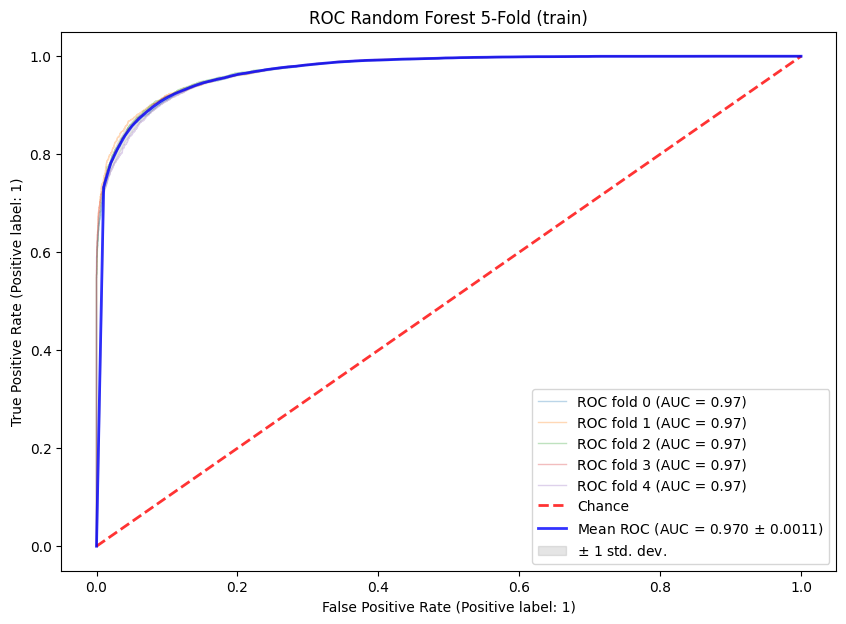

In [64]:
mean_tpr_rf, mean_fpr_rf = plot_roc_kfold(
    rf_best_estimator, cv, X_scalar, y_train, "ROC Random Forest 5-Fold (train)"
)

Let's check on simulated test data :

In [65]:
auc_score = roc_auc_score(
    y_validation, rf_best_estimator.predict_proba(X_validation)[:, 1]
)
print("ROC AUC score of our simulated 'TEST' set: " + str(auc_score))

ROC AUC score of our simulated 'TEST' set: 0.9729812343664165


Sanity check to make sure we don't suffer from overfitting even after the dimension reduction:

- Mean ROC AUC train = 0.970
- ROC AUC validation = 0.972

The difference between the two is minimal, so there is no over fitting!

### <font color=white>Feature importance</font>

**After recieving good results on Random Forest model, we want to get insights on our features.** <br>
Therefore, we plot our feature importance to see how each and every one of them affect the results. <br>
With that plot we will decide whether we need to reduce the ammount of features or to stick with what we accomplished.

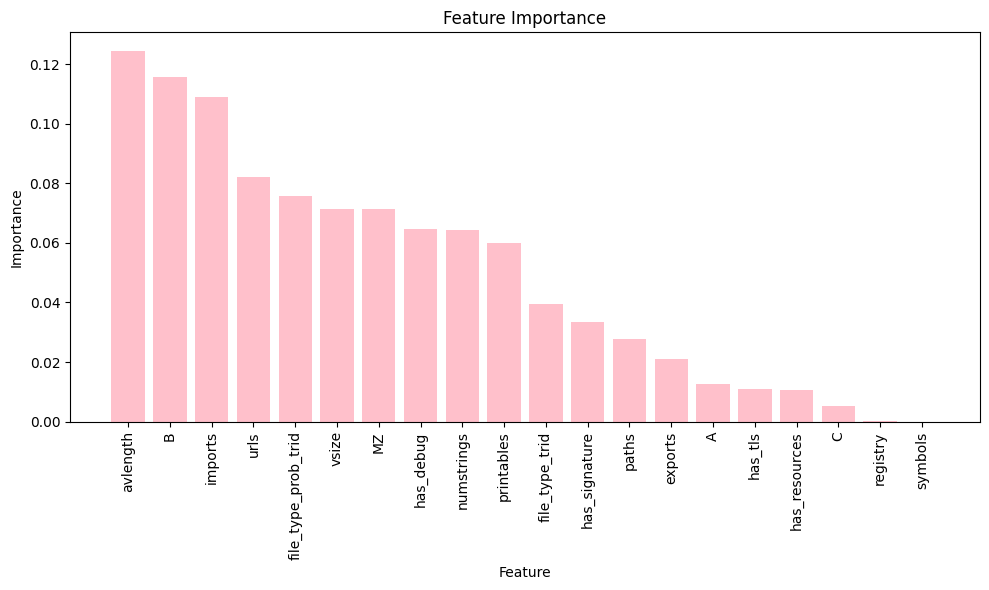

In [66]:
# Get feature importances from our Random Forest model
feature_importances = rf_best_estimator.feature_importances_
# Create mask to find the feature names
measures = np.argsort(feature_importances)[::-1]
names = train_cpy_imputed.columns[measures]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(
    range(train_cpy_imputed.shape[1] - 1), feature_importances[measures], color="pink"
)
plt.xticks(range(train_cpy_imputed.shape[1] - 1), names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

It is interesting how important **'avlength'** is to our model. <br>
'avlength' = the average string length. <br>

Intuitively - Malicious code might contain unusually long or short strings compared to benign code. This characteristic can indicate attempts to hide malicious intent. For instance, excessively long strings could be used to embed encoded payloads or command strings, while very short strings might be used to minimize the footprint of specific malicious operations. <br>

That explains why this feature is so important to our model!

As we thought earlier, the feature 'symbols' doesn't contribute to our model. As we've seen before there were many unusual values ​​that were removed and currently all of its values ​​are 0. That explains why this feature doesn't contribute to our model.

### <font color=white>Confusion Matrix</font>

Lets move on and examine the **Confusion Matrix of Random Forest** 

Train Set Metrics:
Accuracy: 0.9423987963320659
Precision: 0.9463055357567118
Sensitivity: 0.9417931034482758
Specificity: 0.9430443548387096
F1 Score: 0.9440439273933912

Validation Set Metrics:
Accuracy: 0.9121666666666667
Precision: 0.9265362169584621
Sensitivity: 0.8960823373173971
Specificity: 0.928380187416332
F1 Score: 0.9110548523206751


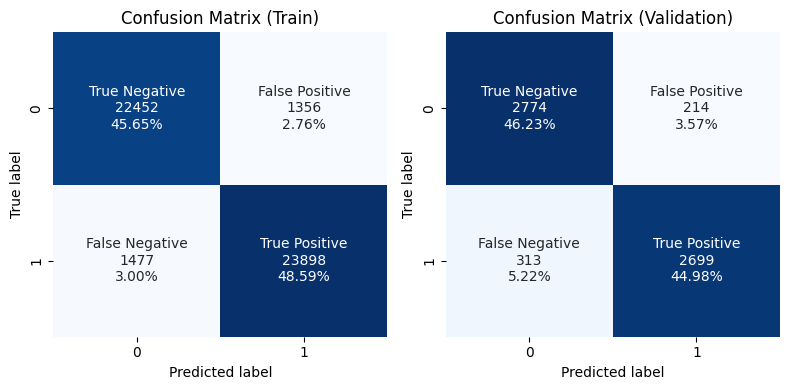

In [67]:
# Predict on train and validation sets
rf_preds_train = rf_best_estimator.predict(X_scalar)
rf_preds_validation = rf_best_estimator.predict(X_validation)

# Compute confusion matrices
cf_matrix_train = confusion_matrix(y_train, rf_preds_train)
cf_matrix_validation = confusion_matrix(y_validation, rf_preds_validation)


# Function to create a confusion matrix plot
def make_confusion_matrix(cf_matrix, **kwargs):
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues", **kwargs)


# Calculate metrics
def calculate_metrics(confusion_matrix):
    (
        true_negative,
        false_positive,
        false_negative,
        true_positive,
    ) = confusion_matrix.ravel()

    accuracy = (true_positive + true_negative) / np.sum(confusion_matrix)
    precision = true_positive / (true_positive + false_positive)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

    return accuracy, precision, sensitivity, specificity, f1_score


# Calculate metrics for train and validation sets
(
    accuracy_train,
    precision_train,
    sensitivity_train,
    specificity_train,
    f1_score_train,
) = calculate_metrics(cf_matrix_train)
(
    accuracy_validation,
    precision_validation,
    sensitivity_validation,
    specificity_validation,
    f1_score_validation,
) = calculate_metrics(cf_matrix_validation)

# Print metrics
print("Train Set Metrics:")
print("Accuracy:", accuracy_train)
print("Precision:", precision_train)
print("Sensitivity:", sensitivity_train)
print("Specificity:", specificity_train)
print("F1 Score:", f1_score_train)
print()

print("Validation Set Metrics:")
print("Accuracy:", accuracy_validation)
print("Precision:", precision_validation)
print("Sensitivity:", sensitivity_validation)
print("Specificity:", specificity_validation)
print("F1 Score:", f1_score_validation)

# Plot the confusion matrices
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
make_confusion_matrix(cf_matrix_train, cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Train)")

plt.subplot(1, 2, 2)
make_confusion_matrix(cf_matrix_validation, cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Validation)")

plt.tight_layout()
plt.show()

We'll look at the **validation** confusion matrix: <br>
~91% predicted labels are correct. <br>
~92% labeled as malicious by our model are actually malicious. <br>
Of all the files that are malicious, we correctly predicted as malicious ~89%.  <br>
Of all the files that aren't malicious, we correctly predicted as clean ~92%. <br><br>
We do see a difference between the Train confusion matrix and the validation confusion matrix: <br>
1. TN - our model labeled more percentage of **benign** files as **benign** on the validation data then on the train data. The difference is a bit less then 1%. <br>
2. TP - our model labeled more percentage of **malicious** files as **malicious** on the train data then on the validation data. The difference is a bit less then 4%. <br>
3. FN - our model labeled more percentage of **malicious** files as **benign** on the validation data then on the train data. The difference is a bit more then 2%. <br>
4. FP - our model labeled more percentage of **benign** files as **malicious** on the validation data then on the train data. The difference is a bit less then 1%. <br><br>Overall we can see that the differences between our train and our validation confusion matrices are minor, which indicates the model is **not overfitted** to our train data. 

Let's look at all of our models on the same plot :

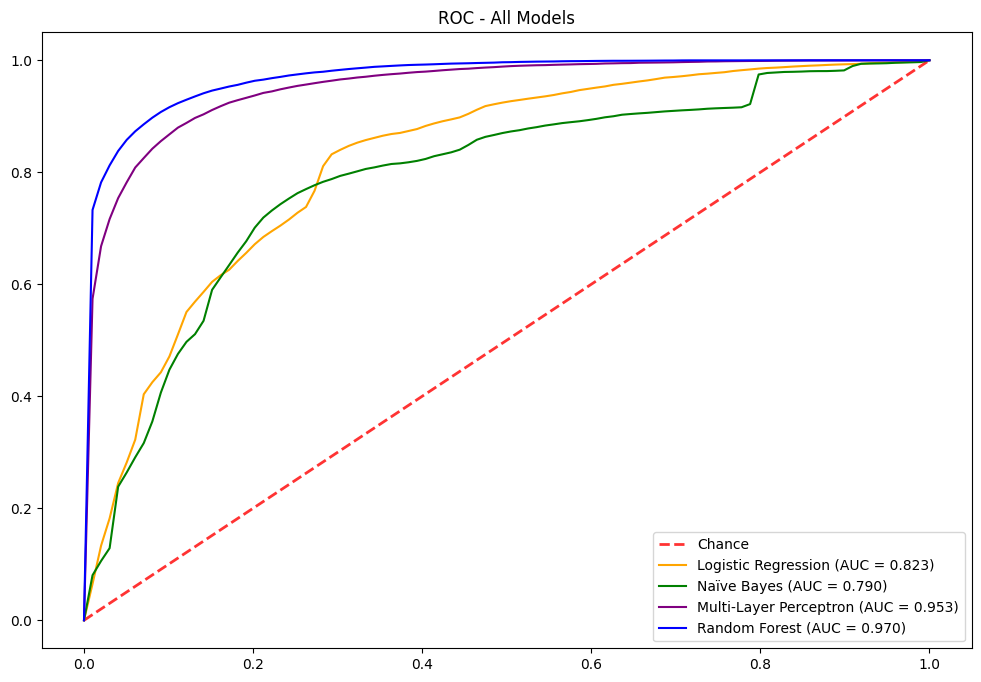

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr_lr,
    mean_tpr_lr,
    color="orange",
    label="Logistic Regression (AUC = %0.3f)" % auc(mean_fpr_lr, mean_tpr_lr),
)
ax.plot(
    mean_fpr_gnb,
    mean_tpr_gnb,
    color="green",
    label="Naïve Bayes (AUC = %0.3f)" % auc(mean_fpr_gnb, mean_tpr_gnb),
)
ax.plot(
    mean_fpr_mlp,
    mean_tpr_mlp,
    color="purple",
    label="Multi-Layer Perceptron (AUC = %0.3f)" % auc(mean_fpr_mlp, mean_tpr_mlp),
)
ax.plot(
    mean_fpr_rf,
    mean_tpr_rf,
    color="blue",
    label="Random Forest (AUC = %0.3f)" % auc(mean_fpr_rf, mean_tpr_rf),
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC - All Models",
)
ax.legend(loc="lower right")
plt.show()

### <font color=white>When comparing all scores of our models, **Random Forest** Performs the best !</font>

# <font color=white> Part 5: Prediction on Test Data</font>

In [69]:
id = pd.DataFrame({"sha256": test_index})
predict_prob = pd.DataFrame(
    {"predict_prob": rf_best_estimator.predict_proba(X_test)[:, 1]}
)

# concatenating the DataFrames and export to csv
pd.concat([id, predict_prob], join="outer", axis=1).to_csv("results_6.csv", index=False)

### <font color=white> **PIPELINE - FINAL MODEL (RANDOM FOREST)**</font>

In [70]:
files = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


files_cpy = files.copy()
test_cpy = test.copy()


files_cpy.drop(labels=["sha256", "has_relocations", "size"], axis=1, inplace=True)
test_index = test_cpy["sha256"]
test_cpy.drop(labels=["sha256", "has_relocations", "size"], axis=1, inplace=True)


numeric = files_cpy.select_dtypes(include=[np.number]).columns
numeric = list(numeric)
bin_col = ["has_debug", "has_tls", "has_signature", "has_resources", "label"]
for col in numeric:
    if col not in bin_col:
        files_cpy[col] = np.log1p(files_cpy[col])
        test_cpy[col] = np.log1p(test_cpy[col])


train_cpy, validation_cpy, y_train, y_validation = train_test_split(
    files_cpy.drop("label", axis=1),
    files_cpy["label"],
    test_size=0.1,
    random_state=42,
    shuffle=True,
)


fill_na_value_counts(train_cpy, validation_cpy, test_cpy, "C")

fill_na_value_counts(train_cpy, validation_cpy, test_cpy, "file_type_trid")
string_count, string_list_test = count_string_values(test_cpy, "file_type_trid")
# handle this problem
for file_type in string_list_test:
    test_cpy["file_type_trid"][test_cpy["file_type_trid"] == file_type] = 0

# Impliment of 'fill_na_binary_columns' function
bin_col = ["has_debug", "has_tls", "has_signature", "has_resources"]
for col in bin_col:
    fill_na_binary_columns(train_cpy, validation_cpy, test_cpy, col)


imputer = KNNImputer(n_neighbors=int(math.sqrt(train_cpy.shape[0])))
X_train_imputed = imputer.fit_transform(train_cpy)
X_validation_imputed = imputer.transform(validation_cpy)
X_test_imputed = imputer.transform(test_cpy)
train_cpy_imputed = pd.DataFrame(X_train_imputed, columns=train_cpy.columns)
validation_cpy_imputed = pd.DataFrame(X_validation_imputed, columns=validation_cpy.columns)
test_cpy_imputed = pd.DataFrame(X_test_imputed, columns=test_cpy.columns)
train_cpy_imputed["label"] = y_train.values
validation_cpy_imputed["label"] = y_validation.values


train_cpy_imputed = remove_outliers(train_cpy_imputed)


X_train, y_train = train_cpy_imputed.values[:, :-1], train_cpy_imputed.values[:, -1]
y_train = y_train.astype("int")
X_validation, y_validation = validation_cpy_imputed.values[:, :-1], validation_cpy_imputed.values[:, -1]
y_validation = y_validation.astype("int")
X_test = test_cpy_imputed.values


scaler = StandardScaler()
X_scalar = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


parameters = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15],
    "min_samples_leaf": [5, 8],
    "criterion": ["gini", "entropy"],
}
rf = RandomForestClassifier(random_state=42)
gscv_rf = GridSearchCV(rf, parameters, scoring="roc_auc", cv=cv, n_jobs=(n_cpu - 1))
gscv_rf.fit(X_scalar, y_train)


id = pd.DataFrame({"sha256": test_index})
predict_prob = pd.DataFrame(
    {"predict_proba": rf_best_estimator.predict_proba(X_test)[:, 1]}
)

# concatenating the DataFrames and export to csv
pd.concat([id, predict_prob], join="outer", axis=1).to_csv("results_6.csv", index=False)

Num of outliers removed for column 'vsize': 0
Num of outliers removed for column 'A': 36
Num of outliers removed for column 'B': 149
Num of outliers removed for column 'numstrings': 0
Num of outliers removed for column 'paths': 280
Num of outliers removed for column 'urls': 0
Num of outliers removed for column 'MZ': 0
Num of outliers removed for column 'printables': 0
Num of outliers removed for column 'avlength': 76
Num of outliers removed for column 'exports': 653
Num of outliers removed for column 'symbols': 1349
Num of outliers removed for column 'registry': 2274


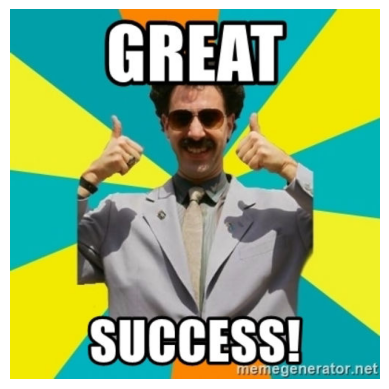

In [71]:
image_url = "https://us-tuna-sounds-images.voicemod.net/cb11073b-df15-4123-9258-00fd77c16533-1654305728370.jpg"
response = requests.get(image_url)
response.raise_for_status()
image = Image.open(BytesIO(response.content))
plt.imshow(image)
plt.axis('off')  
plt.show()
